In [91]:
import numpy as np
import torch
from torch import nn
import tqdm

In [92]:
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

106
12
40
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


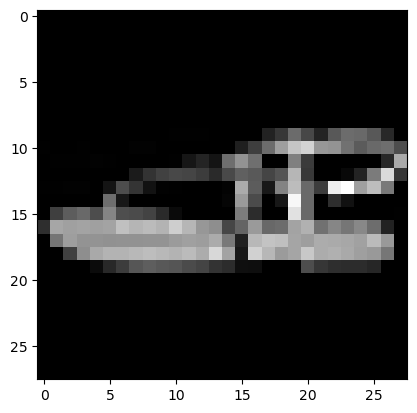

Label: 5
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


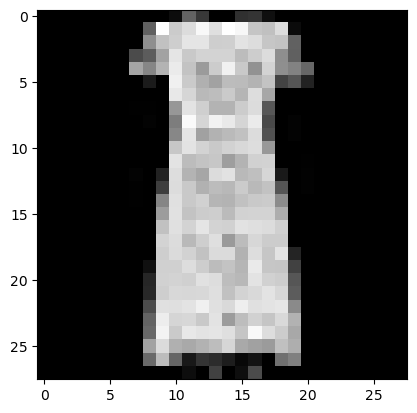

Label: 3
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


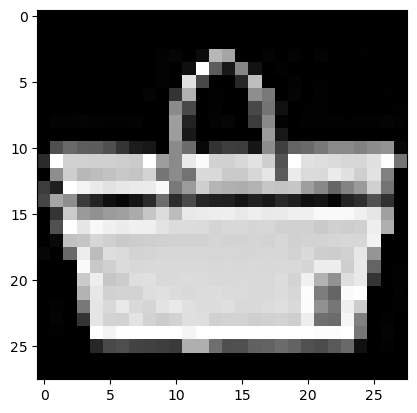

Label: 8
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


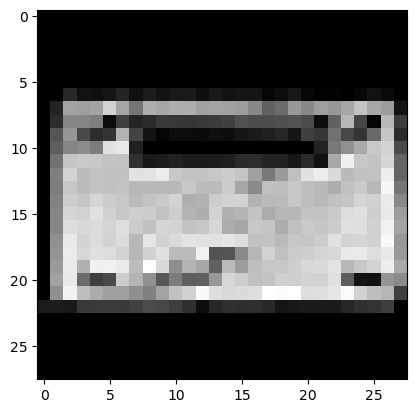

Label: 8
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


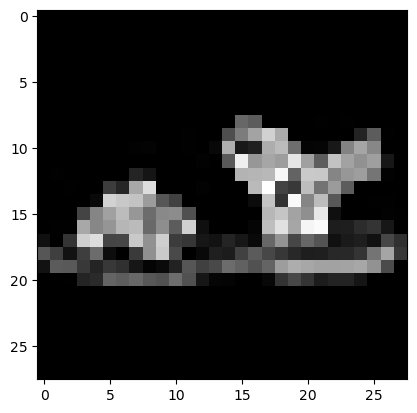

Label: 5
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


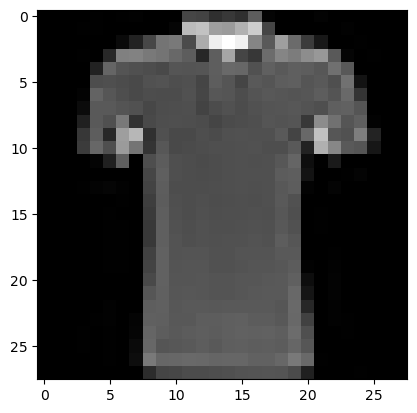

Label: 0
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


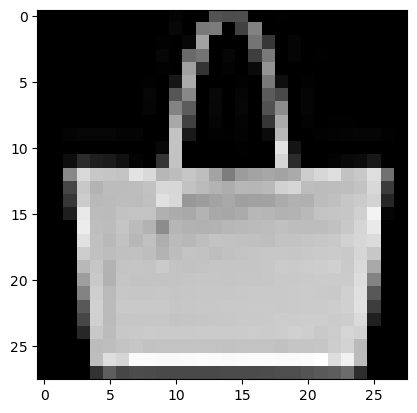

Label: 8
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


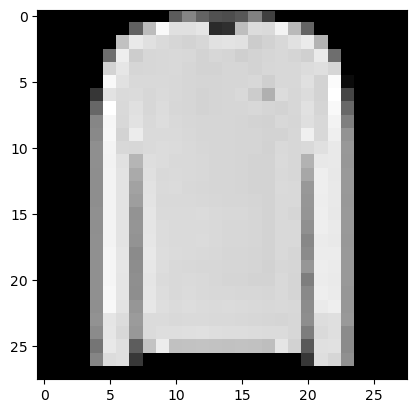

Label: 2
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


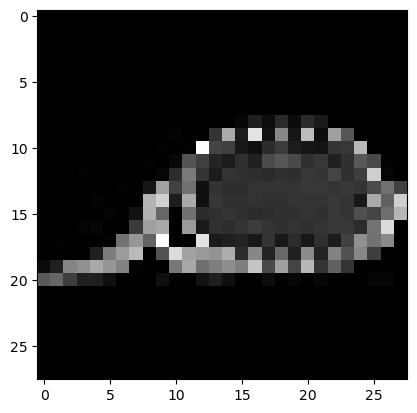

Label: 8
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


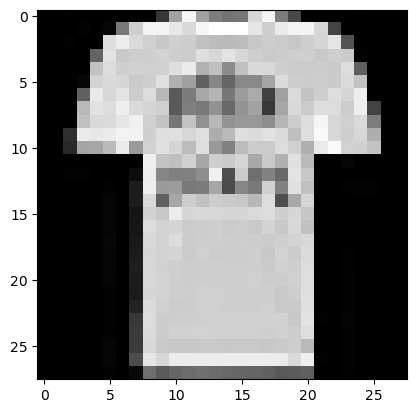

Label: 0
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


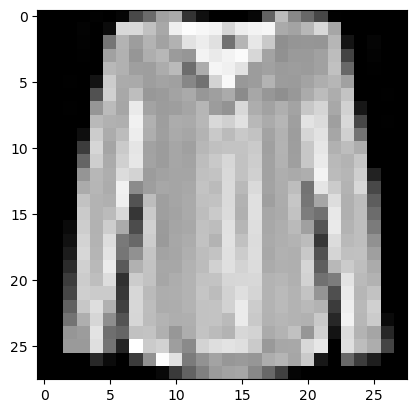

Label: 6
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


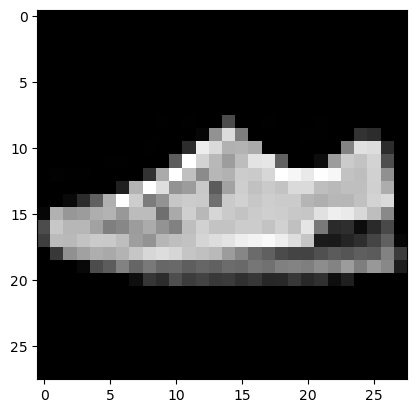

Label: 7
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


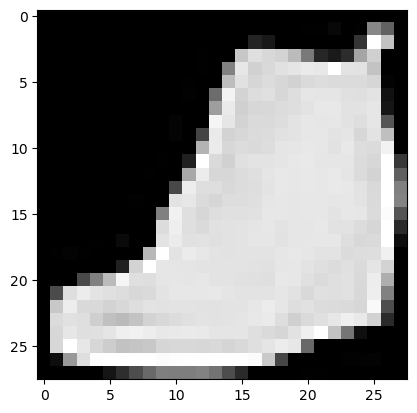

Label: 9
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


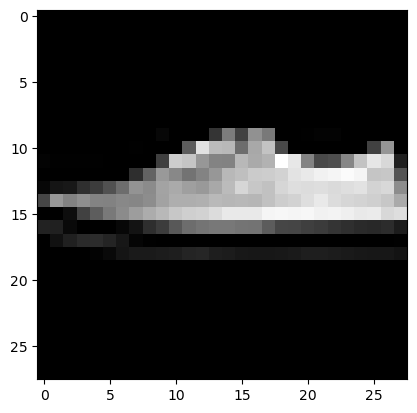

Label: 7
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


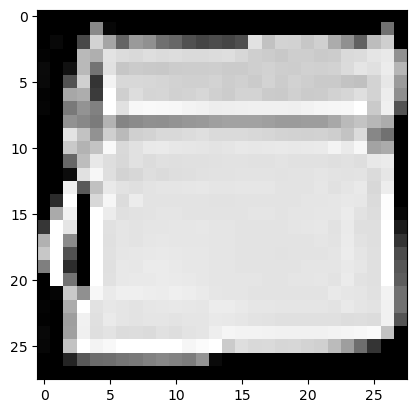

Label: 8
Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


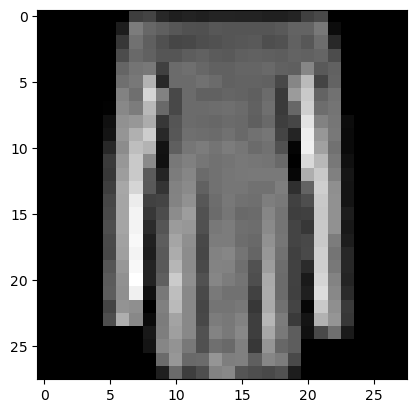

Label: 3


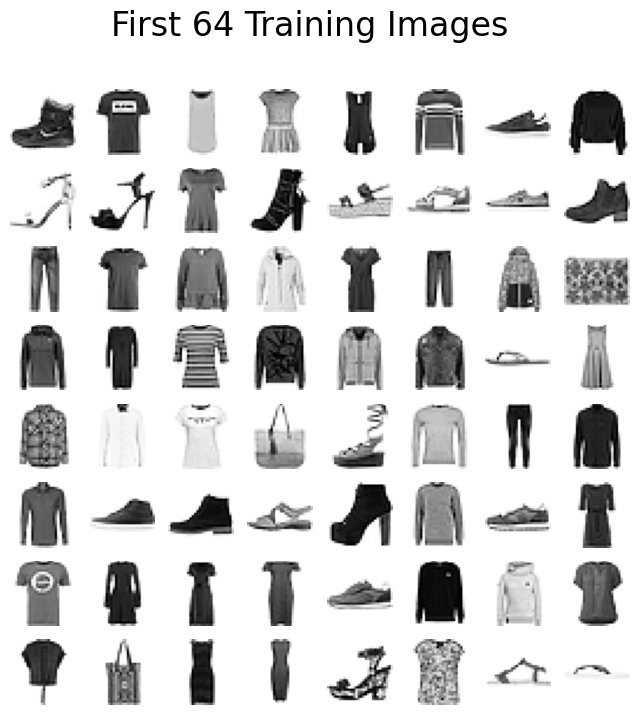

In [93]:
# Use the following code to load and normalize the dataset for training and testing
# Transform the data to tensor, so that pytorch can work on it
# It will downlad the dataset into data subfolder (change to your data folder name)
train_dataset = torchvision.datasets.FashionMNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.FashionMNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


# Use the following code to create a validation set of 10%, from the training set
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.1,
)

# Generate training and validation subsets based on indices
train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)


# set batches sizes
train_batch_size = 512 #Define train batch size
test_batch_size  = 256 #Define test batch size (can be larger than train batch size)


# Define dataloader objects that help to iterate over batches and samples for
# training, validation and testing
train_batches = DataLoader(train_split, batch_size = train_batch_size, shuffle = True)
val_batches = DataLoader(val_split, batch_size = train_batch_size, shuffle = True)
test_batches = DataLoader(test_dataset, batch_size = test_batch_size, shuffle = True)
                                           
num_train_batches = len(train_batches)
num_val_batches = len(val_batches)
num_test_batches = len(test_batches)


print(num_train_batches)
print(num_val_batches)
print(num_test_batches)


#Sample code to visulaize the first sample in first 16 batches 

batch_num = 0
for train_features, train_labels in train_batches:
    
    if batch_num == 16:
        break    # break here
    
    batch_num = batch_num +1
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(img, cmap="gray")
    plt.show()
    print(f"Label: {label}")



# Sample code to plot N^2 images from the dataset
def plot_images(XX, N, title):
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[(N)*i+j], cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

plot_images(train_dataset.data[:64], 8, "First 64 Training Images" )

    

**First, find a baseline configuration using SGD**

In [62]:
#Define your (As Cool As It Gets) Fully Connected Neural Network 
class ACAIGFCN(nn.Module):
    #Initialize model layers, add additional arguments to adjust
    def __init__(self, input_dim, output_dim, hidden_dims): 
        '''
        Parameter:
        hidden_dims: a list. The length is the number of hidden layers, each the values stands for the number of neurons 
        in each hidden layer.
        '''
        super(ACAIGFCN, self).__init__()
        
        #Define the network layer(s) and activation function(s)
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims)-1)])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, input):
        #Define how your model propagates the input through the network

        output = torch.nn.functional.relu(self.input_layer(input))
        for hidden_layer in self.hidden_layers:
            output = torch.nn.functional.relu(hidden_layer(output))
            # Return the final raw output
        
        output = self.output_layer(output)
        
        return output

In [63]:
# Initialize neural network model with input, output and hidden layer dimensions
hidden_dims = np.array([500, 300, 200, 100])
model = ACAIGFCN(input_dim = 784, output_dim = 10, hidden_dims = hidden_dims) #... add more parameters
                
# Define the learning rate and epochs number
# learning_rate = 0.0001
epochs = 70


train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))

validation_accuracy_list = np.zeros((epochs,))

# Define loss function  and optimizer
loss_func = torch.nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.03) # Use optimizers from torch.optim-0.03
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)
# optimizer = torch.optim.RMSprop(model.parameters(), lr= 0.001)


model

ACAIGFCN(
  (input_layer): Linear(in_features=784, out_features=500, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=500, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
)

In [64]:
# Iterate over epochs, batches with progress bar and train+ validate the ACAIGFCN
# Track the loss and validation accuracy
for epoch in tqdm.trange(epochs):

    # ACAIGFCN Training 
    for train_features, train_labels in train_batches:
        # Set model into training mode
        model.train()
        
        # Reshape images into a vector
        train_features = train_features.reshape(-1, 28*28)

        # Reset gradients, Calculate training loss on model
        optimizer.zero_grad()
        output = model(train_features) # foward method
        # Calculate the loss using your loss function and labels
        loss = loss_func(output, train_labels)
    
        train_loss_list[epoch] = loss.item()
        
        loss.backward()
        
        optimizer.step()
        # Perfrom optimization, back propagation
        
 
    # Record loss for the epoch
    
    # ACAIGFCN Validation
    for val_features, val_labels in val_batches:
        
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad(): 
            model.eval()
            
             # Reshape validation images into a vector
            val_features = val_features.reshape(-1, 28 * 28)
          
            # Compute validation outputs (targets)
            validation_outputs = model(val_features)
            val_loss = loss_func(validation_outputs, val_labels)
            val_loss_list[epoch] = val_loss.item()
            
            correct = (torch.argmax(validation_outputs, dim=1) == val_labels).type(torch.FloatTensor)
        
            validation_accuracy_list[epoch] = correct.mean()
            # and compute accuracy 
            
    # Record accuracy for the epoch; print training loss, validation accuracy
    print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(validation_accuracy_list[epoch].item() * 100) + '%')



  1%|▋                                           | 1/70 [00:02<03:20,  2.91s/it]

Epoch: 0; Validation Accuracy:76.63043737411499%


  3%|█▎                                          | 2/70 [00:05<03:17,  2.90s/it]

Epoch: 1; Validation Accuracy:81.25%


  4%|█▉                                          | 3/70 [00:08<03:16,  2.93s/it]

Epoch: 2; Validation Accuracy:81.521737575531%


  6%|██▌                                         | 4/70 [00:11<03:13,  2.93s/it]

Epoch: 3; Validation Accuracy:81.79348111152649%


  7%|███▏                                        | 5/70 [00:14<03:10,  2.93s/it]

Epoch: 4; Validation Accuracy:83.69565010070801%


  9%|███▊                                        | 6/70 [00:17<03:06,  2.92s/it]

Epoch: 5; Validation Accuracy:87.228262424469%


 10%|████▍                                       | 7/70 [00:20<03:03,  2.92s/it]

Epoch: 6; Validation Accuracy:84.78260636329651%


 11%|█████                                       | 8/70 [00:23<03:00,  2.91s/it]

Epoch: 7; Validation Accuracy:83.423912525177%


 13%|█████▋                                      | 9/70 [00:26<02:59,  2.94s/it]

Epoch: 8; Validation Accuracy:87.771737575531%


 14%|██████▏                                    | 10/70 [00:29<02:57,  2.95s/it]

Epoch: 9; Validation Accuracy:87.5%


 16%|██████▊                                    | 11/70 [00:32<02:53,  2.95s/it]

Epoch: 10; Validation Accuracy:86.4130437374115%


 17%|███████▎                                   | 12/70 [00:35<02:50,  2.93s/it]

Epoch: 11; Validation Accuracy:89.13043737411499%


 19%|███████▉                                   | 13/70 [00:38<02:46,  2.92s/it]

Epoch: 12; Validation Accuracy:84.5108687877655%


 20%|████████▌                                  | 14/70 [00:41<02:44,  2.94s/it]

Epoch: 13; Validation Accuracy:89.13043737411499%


 21%|█████████▏                                 | 15/70 [00:43<02:40,  2.92s/it]

Epoch: 14; Validation Accuracy:89.402174949646%


 23%|█████████▊                                 | 16/70 [00:46<02:37,  2.91s/it]

Epoch: 15; Validation Accuracy:87.771737575531%


 24%|██████████▍                                | 17/70 [00:49<02:34,  2.92s/it]

Epoch: 16; Validation Accuracy:91.576087474823%


 26%|███████████                                | 18/70 [00:52<02:31,  2.92s/it]

Epoch: 17; Validation Accuracy:88.5869562625885%


 27%|███████████▋                               | 19/70 [00:55<02:28,  2.92s/it]

Epoch: 18; Validation Accuracy:89.13043737411499%


 29%|████████████▎                              | 20/70 [00:58<02:28,  2.97s/it]

Epoch: 19; Validation Accuracy:87.228262424469%


 30%|████████████▉                              | 21/70 [01:01<02:24,  2.96s/it]

Epoch: 20; Validation Accuracy:90.7608687877655%


 31%|█████████████▌                             | 22/70 [01:04<02:21,  2.96s/it]

Epoch: 21; Validation Accuracy:88.8586938381195%


 33%|██████████████▏                            | 23/70 [01:07<02:18,  2.95s/it]

Epoch: 22; Validation Accuracy:88.04348111152649%


 34%|██████████████▋                            | 24/70 [01:10<02:15,  2.94s/it]

Epoch: 23; Validation Accuracy:83.423912525177%


 36%|███████████████▎                           | 25/70 [01:13<02:17,  3.05s/it]

Epoch: 24; Validation Accuracy:88.5869562625885%


 37%|███████████████▉                           | 26/70 [01:16<02:15,  3.08s/it]

Epoch: 25; Validation Accuracy:90.4891312122345%


 39%|████████████████▌                          | 27/70 [01:19<02:11,  3.05s/it]

Epoch: 26; Validation Accuracy:90.7608687877655%


 40%|█████████████████▏                         | 28/70 [01:22<02:06,  3.01s/it]

Epoch: 27; Validation Accuracy:85.86956262588501%


 41%|█████████████████▊                         | 29/70 [01:25<02:03,  3.01s/it]

Epoch: 28; Validation Accuracy:89.94565010070801%


 43%|██████████████████▍                        | 30/70 [01:28<02:00,  3.02s/it]

Epoch: 29; Validation Accuracy:88.04348111152649%


 44%|███████████████████                        | 31/70 [01:31<01:56,  2.99s/it]

Epoch: 30; Validation Accuracy:84.78260636329651%


 46%|███████████████████▋                       | 32/70 [01:34<01:52,  2.97s/it]

Epoch: 31; Validation Accuracy:89.673912525177%


 47%|████████████████████▎                      | 33/70 [01:37<01:49,  2.96s/it]

Epoch: 32; Validation Accuracy:90.21739363670349%


 49%|████████████████████▉                      | 34/70 [01:40<01:46,  2.95s/it]

Epoch: 33; Validation Accuracy:89.402174949646%


 50%|█████████████████████▌                     | 35/70 [01:43<01:43,  2.95s/it]

Epoch: 34; Validation Accuracy:86.95651888847351%


 51%|██████████████████████                     | 36/70 [01:46<01:40,  2.96s/it]

Epoch: 35; Validation Accuracy:89.673912525177%


 53%|██████████████████████▋                    | 37/70 [01:49<01:37,  2.95s/it]

Epoch: 36; Validation Accuracy:86.1413061618805%


 54%|███████████████████████▎                   | 38/70 [01:52<01:34,  2.94s/it]

Epoch: 37; Validation Accuracy:89.13043737411499%


 56%|███████████████████████▉                   | 39/70 [01:55<01:31,  2.96s/it]

Epoch: 38; Validation Accuracy:88.5869562625885%


 57%|████████████████████████▌                  | 40/70 [01:58<01:28,  2.96s/it]

Epoch: 39; Validation Accuracy:90.4891312122345%


 59%|█████████████████████████▏                 | 41/70 [02:01<01:26,  2.99s/it]

Epoch: 40; Validation Accuracy:90.4891312122345%


 60%|█████████████████████████▊                 | 42/70 [02:04<01:23,  2.98s/it]

Epoch: 41; Validation Accuracy:89.402174949646%


 61%|██████████████████████████▍                | 43/70 [02:07<01:20,  2.96s/it]

Epoch: 42; Validation Accuracy:88.5869562625885%


 63%|███████████████████████████                | 44/70 [02:10<01:16,  2.95s/it]

Epoch: 43; Validation Accuracy:87.771737575531%


 64%|███████████████████████████▋               | 45/70 [02:13<01:13,  2.94s/it]

Epoch: 44; Validation Accuracy:90.4891312122345%


 66%|████████████████████████████▎              | 46/70 [02:15<01:10,  2.94s/it]

Epoch: 45; Validation Accuracy:90.4891312122345%


 67%|████████████████████████████▊              | 47/70 [02:18<01:07,  2.96s/it]

Epoch: 46; Validation Accuracy:89.13043737411499%


 69%|█████████████████████████████▍             | 48/70 [02:21<01:04,  2.95s/it]

Epoch: 47; Validation Accuracy:90.4891312122345%


 70%|██████████████████████████████             | 49/70 [02:24<01:02,  2.98s/it]

Epoch: 48; Validation Accuracy:89.673912525177%


 71%|██████████████████████████████▋            | 50/70 [02:27<00:59,  2.98s/it]

Epoch: 49; Validation Accuracy:91.576087474823%


 73%|███████████████████████████████▎           | 51/70 [02:30<00:56,  2.96s/it]

Epoch: 50; Validation Accuracy:85.326087474823%


 74%|███████████████████████████████▉           | 52/70 [02:33<00:53,  2.97s/it]

Epoch: 51; Validation Accuracy:87.771737575531%


 76%|████████████████████████████████▌          | 53/70 [02:36<00:50,  2.96s/it]

Epoch: 52; Validation Accuracy:89.94565010070801%


 77%|█████████████████████████████████▏         | 54/70 [02:39<00:47,  2.95s/it]

Epoch: 53; Validation Accuracy:89.13043737411499%


 79%|█████████████████████████████████▊         | 55/70 [02:42<00:44,  2.99s/it]

Epoch: 54; Validation Accuracy:90.21739363670349%


 80%|██████████████████████████████████▍        | 56/70 [02:45<00:41,  2.99s/it]

Epoch: 55; Validation Accuracy:89.94565010070801%


 81%|███████████████████████████████████        | 57/70 [02:48<00:39,  3.00s/it]

Epoch: 56; Validation Accuracy:85.326087474823%


 83%|███████████████████████████████████▋       | 58/70 [02:51<00:36,  3.02s/it]

Epoch: 57; Validation Accuracy:88.8586938381195%


 84%|████████████████████████████████████▏      | 59/70 [02:54<00:33,  3.01s/it]

Epoch: 58; Validation Accuracy:87.5%


 86%|████████████████████████████████████▊      | 60/70 [02:58<00:30,  3.09s/it]

Epoch: 59; Validation Accuracy:90.7608687877655%


 87%|█████████████████████████████████████▍     | 61/70 [03:01<00:29,  3.30s/it]

Epoch: 60; Validation Accuracy:88.04348111152649%


 89%|██████████████████████████████████████     | 62/70 [03:06<00:28,  3.62s/it]

Epoch: 61; Validation Accuracy:89.13043737411499%


 90%|██████████████████████████████████████▋    | 63/70 [03:09<00:24,  3.47s/it]

Epoch: 62; Validation Accuracy:88.8586938381195%


 91%|███████████████████████████████████████▎   | 64/70 [03:12<00:20,  3.37s/it]

Epoch: 63; Validation Accuracy:91.847825050354%


 93%|███████████████████████████████████████▉   | 65/70 [03:15<00:16,  3.23s/it]

Epoch: 64; Validation Accuracy:88.5869562625885%


 94%|████████████████████████████████████████▌  | 66/70 [03:18<00:12,  3.18s/it]

Epoch: 65; Validation Accuracy:91.576087474823%


 96%|█████████████████████████████████████████▏ | 67/70 [03:21<00:09,  3.16s/it]

Epoch: 66; Validation Accuracy:92.3913061618805%


 97%|█████████████████████████████████████████▊ | 68/70 [03:24<00:06,  3.12s/it]

Epoch: 67; Validation Accuracy:86.95651888847351%


 99%|██████████████████████████████████████████▍| 69/70 [03:27<00:03,  3.08s/it]

Epoch: 68; Validation Accuracy:91.847825050354%


100%|███████████████████████████████████████████| 70/70 [03:30<00:00,  3.01s/it]

Epoch: 69; Validation Accuracy:89.402174949646%


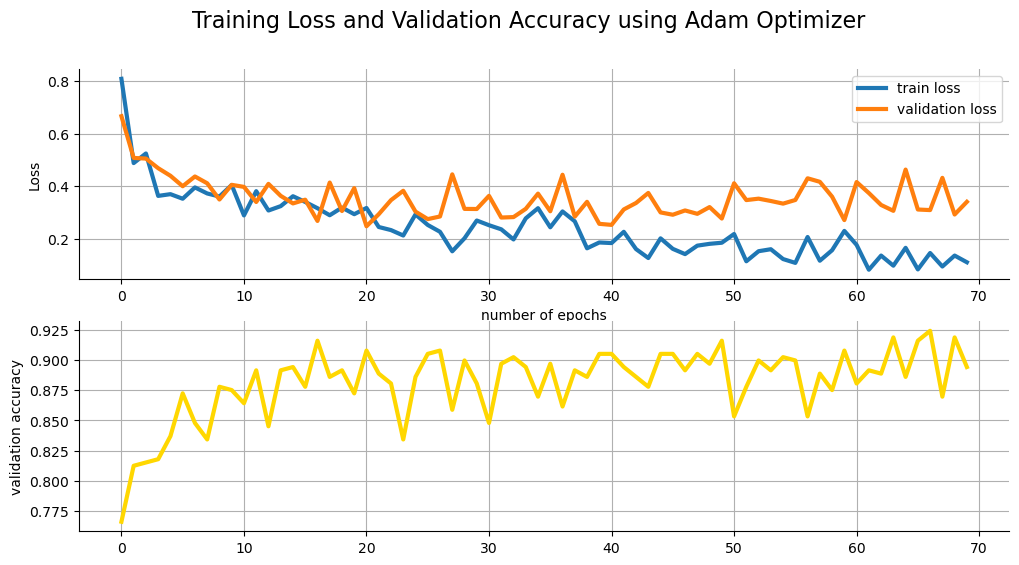

In [65]:
# Plot training loss and validation accuracy throughout the training epochs
import seaborn as sns


plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3, label = "train loss")
plt.plot(val_loss_list, linewidth = 3, label = "validation loss")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.grid(True)

plt.suptitle("Training Loss and Validation Accuracy using Adam Optimizer", fontsize=16)

sns.despine()

In [129]:
#Calculate accuracy on test set

# Telling PyTorch we aren't passing inputs to network for training purpose
with torch.no_grad():

    total_accuracies = []
    
    for test_features, test_labels in test_batches:

        model.eval()
        # Reshape test images into a vector
        test_features = test_features.reshape(-1, 28*28)

         # Compute validation outputs (targets) 
        y_pred_test = model(test_features) 
        
         # and compute accuracy 
        batch_correct = (torch.argmax(y_pred_test, dim=1) == test_labels).type(torch.FloatTensor)
        batch_accuracy = batch_correct.mean()
        total_accuracies.append(batch_accuracy.numpy())
      
    # Compute total (mean) accuracy
    testing_acc = np.mean(total_accuracies)
    testing_std = np.std(total_accuracies)

    print("Testing Accuracy: {:.2f}% ± {:.2f}%".format(testing_acc * 100, testing_std * 100))
    # Report total (mean) accuracy, can also compute std based on batches


Testing Accuracy: 89.70% ± 1.94%


**Then, try the effect of dropout on overfitting and underfitting.**

In [113]:
# Create a new model with dropout

class ACAIGFCNDropout(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout_rate=0.5):
        super(ACAIGFCNDropout, self).__init__()

        # Define the network layers and activation functions
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims)-1)])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        # Add dropout layers
        self.dropout_layers = nn.ModuleList([nn.Dropout(p=dropout_rate) for _ in range(len(hidden_dims))])

    def forward(self, input):
        # Define how your model propagates the input through the network

        output = torch.nn.functional.relu(self.input_layer(input))
        
        for hidden_layer, dropout_layer in zip(self.hidden_layers, self.dropout_layers):
            output = torch.nn.functional.relu(hidden_layer(output))
            output = dropout_layer(output)  # Apply dropout after activation

        output = self.output_layer(output)

        return output

In [114]:
hidden_dims = np.array([500, 300, 200, 100])
model = ACAIGFCNDropout(input_dim = 784, output_dim = 10, hidden_dims = hidden_dims, dropout_rate=0.5) #... add more parameters
                
# Define the learning rate and epochs number
# learning_rate = 0.0001
epochs = 70


train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))

validation_accuracy_list = np.zeros((epochs,))

# Define loss function  and optimizer
loss_func = torch.nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001) # Use optimizers from torch.optim
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)
# optimizer = torch.optim.RMSprop(model.parameters(), lr= 0.0001)

model

ACAIGFCNDropout(
  (input_layer): Linear(in_features=784, out_features=500, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=500, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
  (dropout_layers): ModuleList(
    (0-3): 4 x Dropout(p=0.5, inplace=False)
  )
)

In [69]:
for epoch in tqdm.trange(epochs):

    # ACAIGFCNDropout Training 
    for train_features, train_labels in train_batches:
        # Set model into training mode
        model.train()
        
        # Reshape images into a vector
        train_features = train_features.reshape(-1, 28*28)

        # Reset gradients, Calculate training loss on model
        optimizer.zero_grad()
        output = model(train_features) # foward method
        # Calculate the loss using your loss function and labels
        loss = loss_func(output, train_labels)
    
        train_loss_list[epoch] = loss.item()
        
        loss.backward()
        
        optimizer.step()
        # Perfrom optimization, back propagation
        
 
    # Record loss for the epoch
    
    # ACAIGFCN Validation
    for val_features, val_labels in val_batches:
        
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad(): 
            model.eval()
            
             # Reshape validation images into a vector
            val_features = val_features.reshape(-1, 28 * 28)
          
            # Compute validation outputs (targets)
            validation_outputs = model(val_features)
            val_loss = loss_func(validation_outputs, val_labels)
            val_loss_list[epoch] = val_loss.item()
            
            correct = (torch.argmax(validation_outputs, dim=1) == val_labels).type(torch.FloatTensor)
        
            validation_accuracy_list[epoch] = correct.mean()
            # and compute accuracy 
            
    # Record accuracy for the epoch; print training loss, validation accuracy
    print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(validation_accuracy_list[epoch].item() * 100) + '%')


  1%|▋                                           | 1/70 [00:03<03:44,  3.25s/it]

Epoch: 0; Validation Accuracy:68.478262424469%


  3%|█▎                                          | 2/70 [00:06<03:44,  3.30s/it]

Epoch: 1; Validation Accuracy:77.173912525177%


  4%|█▉                                          | 3/70 [00:09<03:35,  3.22s/it]

Epoch: 2; Validation Accuracy:81.521737575531%


  6%|██▌                                         | 4/70 [00:12<03:32,  3.22s/it]

Epoch: 3; Validation Accuracy:81.521737575531%


  7%|███▏                                        | 5/70 [00:16<03:26,  3.17s/it]

Epoch: 4; Validation Accuracy:81.521737575531%


  9%|███▊                                        | 6/70 [00:19<03:20,  3.13s/it]

Epoch: 5; Validation Accuracy:83.69565010070801%


 10%|████▍                                       | 7/70 [00:22<03:21,  3.20s/it]

Epoch: 6; Validation Accuracy:86.6847813129425%


 11%|█████                                       | 8/70 [00:25<03:17,  3.18s/it]

Epoch: 7; Validation Accuracy:84.5108687877655%


 13%|█████▋                                      | 9/70 [00:28<03:14,  3.19s/it]

Epoch: 8; Validation Accuracy:90.21739363670349%


 14%|██████▏                                    | 10/70 [00:32<03:13,  3.22s/it]

Epoch: 9; Validation Accuracy:87.5%


 16%|██████▊                                    | 11/70 [00:35<03:11,  3.25s/it]

Epoch: 10; Validation Accuracy:86.6847813129425%


 17%|███████▎                                   | 12/70 [00:38<03:09,  3.26s/it]

Epoch: 11; Validation Accuracy:87.5%


 19%|███████▉                                   | 13/70 [00:41<03:03,  3.22s/it]

Epoch: 12; Validation Accuracy:84.78260636329651%


 20%|████████▌                                  | 14/70 [00:45<03:01,  3.25s/it]

Epoch: 13; Validation Accuracy:87.5%


 21%|█████████▏                                 | 15/70 [00:48<02:58,  3.25s/it]

Epoch: 14; Validation Accuracy:85.05434989929199%


 23%|█████████▊                                 | 16/70 [00:51<02:54,  3.22s/it]

Epoch: 15; Validation Accuracy:88.04348111152649%


 24%|██████████▍                                | 17/70 [00:54<02:50,  3.22s/it]

Epoch: 16; Validation Accuracy:86.4130437374115%


 26%|███████████                                | 18/70 [00:57<02:44,  3.17s/it]

Epoch: 17; Validation Accuracy:88.8586938381195%


 27%|███████████▋                               | 19/70 [01:00<02:40,  3.14s/it]

Epoch: 18; Validation Accuracy:86.95651888847351%


 29%|████████████▎                              | 20/70 [01:03<02:36,  3.13s/it]

Epoch: 19; Validation Accuracy:89.673912525177%


 30%|████████████▉                              | 21/70 [01:07<02:32,  3.11s/it]

Epoch: 20; Validation Accuracy:84.78260636329651%


 31%|█████████████▌                             | 22/70 [01:10<02:29,  3.12s/it]

Epoch: 21; Validation Accuracy:89.402174949646%


 33%|██████████████▏                            | 23/70 [01:13<02:25,  3.11s/it]

Epoch: 22; Validation Accuracy:87.771737575531%


 34%|██████████████▋                            | 24/70 [01:16<02:22,  3.10s/it]

Epoch: 23; Validation Accuracy:91.03260636329651%


 36%|███████████████▎                           | 25/70 [01:19<02:19,  3.10s/it]

Epoch: 24; Validation Accuracy:88.5869562625885%


 37%|███████████████▉                           | 26/70 [01:22<02:17,  3.11s/it]

Epoch: 25; Validation Accuracy:91.03260636329651%


 39%|████████████████▌                          | 27/70 [01:25<02:14,  3.12s/it]

Epoch: 26; Validation Accuracy:89.402174949646%


 40%|█████████████████▏                         | 28/70 [01:28<02:10,  3.11s/it]

Epoch: 27; Validation Accuracy:86.95651888847351%


 41%|█████████████████▊                         | 29/70 [01:31<02:07,  3.11s/it]

Epoch: 28; Validation Accuracy:88.04348111152649%


 43%|██████████████████▍                        | 30/70 [01:34<02:03,  3.10s/it]

Epoch: 29; Validation Accuracy:88.8586938381195%


 44%|███████████████████                        | 31/70 [01:38<02:00,  3.09s/it]

Epoch: 30; Validation Accuracy:90.21739363670349%


 46%|███████████████████▋                       | 32/70 [01:41<01:58,  3.11s/it]

Epoch: 31; Validation Accuracy:86.6847813129425%


 47%|████████████████████▎                      | 33/70 [01:44<01:54,  3.10s/it]

Epoch: 32; Validation Accuracy:88.04348111152649%


 49%|████████████████████▉                      | 34/70 [01:47<01:51,  3.09s/it]

Epoch: 33; Validation Accuracy:88.8586938381195%


 50%|█████████████████████▌                     | 35/70 [01:50<01:47,  3.09s/it]

Epoch: 34; Validation Accuracy:90.21739363670349%


 51%|██████████████████████                     | 36/70 [01:53<01:45,  3.10s/it]

Epoch: 35; Validation Accuracy:89.13043737411499%


 53%|██████████████████████▋                    | 37/70 [01:56<01:42,  3.11s/it]

Epoch: 36; Validation Accuracy:89.402174949646%


 54%|███████████████████████▎                   | 38/70 [01:59<01:39,  3.12s/it]

Epoch: 37; Validation Accuracy:87.5%


 56%|███████████████████████▉                   | 39/70 [02:02<01:36,  3.13s/it]

Epoch: 38; Validation Accuracy:90.21739363670349%


 57%|████████████████████████▌                  | 40/70 [02:06<01:33,  3.13s/it]

Epoch: 39; Validation Accuracy:86.4130437374115%


 59%|█████████████████████████▏                 | 41/70 [02:09<01:30,  3.11s/it]

Epoch: 40; Validation Accuracy:86.6847813129425%


 60%|█████████████████████████▊                 | 42/70 [02:12<01:27,  3.13s/it]

Epoch: 41; Validation Accuracy:89.94565010070801%


 61%|██████████████████████████▍                | 43/70 [02:15<01:24,  3.14s/it]

Epoch: 42; Validation Accuracy:89.673912525177%


 63%|███████████████████████████                | 44/70 [02:18<01:21,  3.12s/it]

Epoch: 43; Validation Accuracy:88.5869562625885%


 64%|███████████████████████████▋               | 45/70 [02:21<01:17,  3.11s/it]

Epoch: 44; Validation Accuracy:87.228262424469%


 66%|████████████████████████████▎              | 46/70 [02:24<01:15,  3.13s/it]

Epoch: 45; Validation Accuracy:90.7608687877655%


 67%|████████████████████████████▊              | 47/70 [02:27<01:11,  3.12s/it]

Epoch: 46; Validation Accuracy:90.7608687877655%


 69%|█████████████████████████████▍             | 48/70 [02:31<01:08,  3.13s/it]

Epoch: 47; Validation Accuracy:90.7608687877655%


 70%|██████████████████████████████             | 49/70 [02:34<01:05,  3.11s/it]

Epoch: 48; Validation Accuracy:89.94565010070801%


 71%|██████████████████████████████▋            | 50/70 [02:37<01:02,  3.10s/it]

Epoch: 49; Validation Accuracy:91.30434989929199%


 73%|███████████████████████████████▎           | 51/70 [02:40<00:58,  3.10s/it]

Epoch: 50; Validation Accuracy:88.04348111152649%


 74%|███████████████████████████████▉           | 52/70 [02:43<00:55,  3.09s/it]

Epoch: 51; Validation Accuracy:88.04348111152649%


 76%|████████████████████████████████▌          | 53/70 [02:46<00:52,  3.10s/it]

Epoch: 52; Validation Accuracy:90.21739363670349%


 77%|█████████████████████████████████▏         | 54/70 [02:49<00:49,  3.10s/it]

Epoch: 53; Validation Accuracy:89.673912525177%


 79%|█████████████████████████████████▊         | 55/70 [02:52<00:46,  3.12s/it]

Epoch: 54; Validation Accuracy:87.228262424469%


 80%|██████████████████████████████████▍        | 56/70 [02:55<00:43,  3.11s/it]

Epoch: 55; Validation Accuracy:89.673912525177%


 81%|███████████████████████████████████        | 57/70 [02:58<00:40,  3.10s/it]

Epoch: 56; Validation Accuracy:87.771737575531%


 83%|███████████████████████████████████▋       | 58/70 [03:02<00:37,  3.12s/it]

Epoch: 57; Validation Accuracy:87.771737575531%


 84%|████████████████████████████████████▏      | 59/70 [03:05<00:34,  3.11s/it]

Epoch: 58; Validation Accuracy:88.8586938381195%


 86%|████████████████████████████████████▊      | 60/70 [03:08<00:31,  3.11s/it]

Epoch: 59; Validation Accuracy:89.402174949646%


 87%|█████████████████████████████████████▍     | 61/70 [03:11<00:27,  3.10s/it]

Epoch: 60; Validation Accuracy:91.576087474823%


 89%|██████████████████████████████████████     | 62/70 [03:14<00:24,  3.10s/it]

Epoch: 61; Validation Accuracy:88.5869562625885%


 90%|██████████████████████████████████████▋    | 63/70 [03:17<00:21,  3.11s/it]

Epoch: 62; Validation Accuracy:84.78260636329651%


 91%|███████████████████████████████████████▎   | 64/70 [03:20<00:18,  3.11s/it]

Epoch: 63; Validation Accuracy:90.21739363670349%


 93%|███████████████████████████████████████▉   | 65/70 [03:23<00:15,  3.12s/it]

Epoch: 64; Validation Accuracy:88.5869562625885%


 94%|████████████████████████████████████████▌  | 66/70 [03:26<00:12,  3.11s/it]

Epoch: 65; Validation Accuracy:88.8586938381195%


 96%|█████████████████████████████████████████▏ | 67/70 [03:30<00:09,  3.10s/it]

Epoch: 66; Validation Accuracy:87.771737575531%


 97%|█████████████████████████████████████████▊ | 68/70 [03:33<00:06,  3.11s/it]

Epoch: 67; Validation Accuracy:89.402174949646%


 99%|██████████████████████████████████████████▍| 69/70 [03:36<00:03,  3.11s/it]

Epoch: 68; Validation Accuracy:90.4891312122345%


100%|███████████████████████████████████████████| 70/70 [03:39<00:00,  3.13s/it]

Epoch: 69; Validation Accuracy:91.03260636329651%


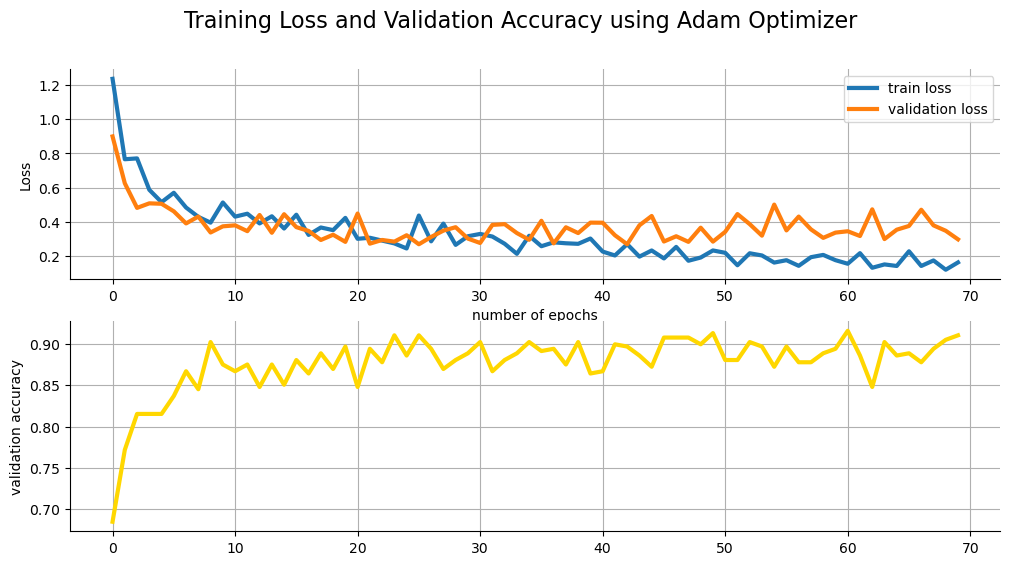

In [72]:
plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3, label = "train loss")
plt.plot(val_loss_list, linewidth = 3, label = "validation loss")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.grid(True)

plt.suptitle("Training Loss and Validation Accuracy using Adam Optimizer", fontsize=16)

sns.despine()

In [133]:
with torch.no_grad():

    total_accuracies = []
    
    for test_features, test_labels in test_batches:

        model.eval()
        # Reshape test images into a vector
        test_features = test_features.reshape(-1, 28*28)

         # Compute validation outputs (targets) 
        y_pred_test = model(test_features) 
        
         # and compute accuracy 
        batch_correct = (torch.argmax(y_pred_test, dim=1) == test_labels).type(torch.FloatTensor)
        batch_accuracy = batch_correct.mean()
        total_accuracies.append(batch_accuracy.numpy())
      
    # Compute total (mean) accuracy
    testing_acc = np.mean(total_accuracies)
    testing_std = np.std(total_accuracies)

    print("Testing Accuracy: {:.2f}% ± {:.2f}%".format(testing_acc * 100, testing_std * 100))

Testing Accuracy: 89.70% ± 1.92%


**Then, try different initialization：Random Normal initialization**

In [78]:
import torch.nn.init as init

def init_weights_random_normal(m):
    if type(m) == nn.Linear:
        init.normal_(m.weight, mean=0, std=1)
        
model_RN = ACAIGFCNDropout(input_dim = 784, output_dim = 10, hidden_dims = hidden_dims, dropout_rate=0.5)
model_RN.apply(init_weights_random_normal)

train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))

# Define loss function  and optimizer
loss_func = torch.nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
optimizer = torch.optim.Adam(model_RN.parameters(), lr= 0.0001)

for epoch in tqdm.trange(epochs):

    # ACAIGFCNDropout Training 
    for train_features, train_labels in train_batches:
        # Set model into training mode
        model_RN.train()
        
        # Reshape images into a vector
        train_features = train_features.reshape(-1, 28*28)

        # Reset gradients, Calculate training loss on model
        optimizer.zero_grad()
        output = model_RN(train_features) # foward method
        # Calculate the loss using your loss function and labels
        loss = loss_func(output, train_labels)
    
        train_loss_list[epoch] = loss.item()
        
        loss.backward()
        
        optimizer.step()
        # Perfrom optimization, back propagation
        
 
    # Record loss for the epoch
    
    # ACAIGFCN Validation
    for val_features, val_labels in val_batches:
        
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad(): 
            model_RN.eval()
            
             # Reshape validation images into a vector
            val_features = val_features.reshape(-1, 28 * 28)
          
            # Compute validation outputs (targets)
            validation_outputs = model_RN(val_features)
            val_loss = loss_func(validation_outputs, val_labels)
            val_loss_list[epoch] = val_loss.item()
            
            correct = (torch.argmax(validation_outputs, dim=1) == val_labels).type(torch.FloatTensor)
        
            validation_accuracy_list[epoch] = correct.mean()
            # and compute accuracy 
            
    # Record accuracy for the epoch; print training loss, validation accuracy
    print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(validation_accuracy_list[epoch].item() * 100) + '%')


  1%|▋                                           | 1/70 [00:03<03:40,  3.19s/it]

Epoch: 0; Validation Accuracy:16.576087474822998%


  3%|█▎                                          | 2/70 [00:06<03:29,  3.09s/it]

Epoch: 1; Validation Accuracy:20.652173459529877%


  4%|█▉                                          | 3/70 [00:09<03:25,  3.06s/it]

Epoch: 2; Validation Accuracy:29.891303181648254%


  6%|██▌                                         | 4/70 [00:12<03:21,  3.05s/it]

Epoch: 3; Validation Accuracy:37.771740555763245%


  7%|███▏                                        | 5/70 [00:15<03:17,  3.04s/it]

Epoch: 4; Validation Accuracy:42.934781312942505%


  9%|███▊                                        | 6/70 [00:18<03:15,  3.06s/it]

Epoch: 5; Validation Accuracy:53.2608687877655%


 10%|████▍                                       | 7/70 [00:21<03:13,  3.06s/it]

Epoch: 6; Validation Accuracy:46.7391312122345%


 11%|█████                                       | 8/70 [00:24<03:09,  3.06s/it]

Epoch: 7; Validation Accuracy:51.35869383811951%


 13%|█████▋                                      | 9/70 [00:27<03:05,  3.05s/it]

Epoch: 8; Validation Accuracy:57.3369562625885%


 14%|██████▏                                    | 10/70 [00:30<03:03,  3.07s/it]

Epoch: 9; Validation Accuracy:48.36956560611725%


 16%|██████▊                                    | 11/70 [00:33<03:01,  3.07s/it]

Epoch: 10; Validation Accuracy:56.79348111152649%


 17%|███████▎                                   | 12/70 [00:36<02:57,  3.06s/it]

Epoch: 11; Validation Accuracy:56.521737575531006%


 19%|███████▉                                   | 13/70 [00:39<02:54,  3.05s/it]

Epoch: 12; Validation Accuracy:56.25%


 20%|████████▌                                  | 14/70 [00:42<02:50,  3.04s/it]

Epoch: 13; Validation Accuracy:56.521737575531006%


 21%|█████████▏                                 | 15/70 [00:45<02:46,  3.03s/it]

Epoch: 14; Validation Accuracy:57.065218687057495%


 23%|█████████▊                                 | 16/70 [00:48<02:44,  3.04s/it]

Epoch: 15; Validation Accuracy:58.423912525177%


 24%|██████████▍                                | 17/70 [00:51<02:41,  3.04s/it]

Epoch: 16; Validation Accuracy:61.4130437374115%


 26%|███████████                                | 18/70 [00:54<02:37,  3.04s/it]

Epoch: 17; Validation Accuracy:57.3369562625885%


 27%|███████████▋                               | 19/70 [00:57<02:34,  3.03s/it]

Epoch: 18; Validation Accuracy:57.60869383811951%


 29%|████████████▎                              | 20/70 [01:01<02:32,  3.05s/it]

Epoch: 19; Validation Accuracy:59.2391312122345%


 30%|████████████▉                              | 21/70 [01:04<02:28,  3.04s/it]

Epoch: 20; Validation Accuracy:56.25%


 31%|█████████████▌                             | 22/70 [01:07<02:26,  3.05s/it]

Epoch: 21; Validation Accuracy:56.521737575531006%


 33%|██████████████▏                            | 23/70 [01:10<02:23,  3.05s/it]

Epoch: 22; Validation Accuracy:57.60869383811951%


 34%|██████████████▋                            | 24/70 [01:13<02:20,  3.04s/it]

Epoch: 23; Validation Accuracy:54.076087474823%


 36%|███████████████▎                           | 25/70 [01:16<02:16,  3.04s/it]

Epoch: 24; Validation Accuracy:48.097825050354004%


 37%|███████████████▉                           | 26/70 [01:19<02:13,  3.03s/it]

Epoch: 25; Validation Accuracy:54.347825050354004%


 39%|████████████████▌                          | 27/70 [01:22<02:11,  3.05s/it]

Epoch: 26; Validation Accuracy:49.184781312942505%


 40%|█████████████████▏                         | 28/70 [01:25<02:07,  3.05s/it]

Epoch: 27; Validation Accuracy:48.097825050354004%


 41%|█████████████████▊                         | 29/70 [01:28<02:04,  3.04s/it]

Epoch: 28; Validation Accuracy:47.28260934352875%


 43%|██████████████████▍                        | 30/70 [01:31<02:02,  3.06s/it]

Epoch: 29; Validation Accuracy:47.55434691905975%


 44%|███████████████████                        | 31/70 [01:34<01:59,  3.05s/it]

Epoch: 30; Validation Accuracy:39.94565308094025%


 46%|███████████████████▋                       | 32/70 [01:37<01:56,  3.07s/it]

Epoch: 31; Validation Accuracy:42.934781312942505%


 47%|████████████████████▎                      | 33/70 [01:40<01:53,  3.06s/it]

Epoch: 32; Validation Accuracy:45.38043439388275%


 49%|████████████████████▉                      | 34/70 [01:43<01:50,  3.06s/it]

Epoch: 33; Validation Accuracy:39.13043439388275%


 50%|█████████████████████▌                     | 35/70 [01:46<01:46,  3.05s/it]

Epoch: 34; Validation Accuracy:40.4891312122345%


 51%|██████████████████████                     | 36/70 [01:49<01:43,  3.05s/it]

Epoch: 35; Validation Accuracy:45.923912525177%


 53%|██████████████████████▋                    | 37/70 [01:52<01:40,  3.06s/it]

Epoch: 36; Validation Accuracy:41.03260934352875%


 54%|███████████████████████▎                   | 38/70 [01:56<01:37,  3.06s/it]

Epoch: 37; Validation Accuracy:39.673912525177%


 56%|███████████████████████▉                   | 39/70 [01:59<01:35,  3.08s/it]

Epoch: 38; Validation Accuracy:41.576087474823%


 57%|████████████████████████▌                  | 40/70 [02:02<01:32,  3.07s/it]

Epoch: 39; Validation Accuracy:35.597825050354004%


 59%|█████████████████████████▏                 | 41/70 [02:05<01:28,  3.06s/it]

Epoch: 40; Validation Accuracy:31.25%


 60%|█████████████████████████▊                 | 42/70 [02:08<01:25,  3.06s/it]

Epoch: 41; Validation Accuracy:28.260868787765503%


 61%|██████████████████████████▍                | 43/70 [02:11<01:23,  3.08s/it]

Epoch: 42; Validation Accuracy:31.25%


 63%|███████████████████████████                | 44/70 [02:14<01:19,  3.07s/it]

Epoch: 43; Validation Accuracy:24.45652186870575%


 64%|███████████████████████████▋               | 45/70 [02:17<01:16,  3.07s/it]

Epoch: 44; Validation Accuracy:25.271740555763245%


 66%|████████████████████████████▎              | 46/70 [02:20<01:13,  3.07s/it]

Epoch: 45; Validation Accuracy:29.891303181648254%


 67%|████████████████████████████▊              | 47/70 [02:23<01:10,  3.06s/it]

Epoch: 46; Validation Accuracy:24.184782803058624%


 69%|█████████████████████████████▍             | 48/70 [02:26<01:07,  3.08s/it]

Epoch: 47; Validation Accuracy:23.097826540470123%


 70%|██████████████████████████████             | 49/70 [02:29<01:04,  3.09s/it]

Epoch: 48; Validation Accuracy:24.184782803058624%


 71%|██████████████████████████████▋            | 50/70 [02:32<01:01,  3.08s/it]

Epoch: 49; Validation Accuracy:25.54347813129425%


 73%|███████████████████████████████▎           | 51/70 [02:36<00:58,  3.08s/it]

Epoch: 50; Validation Accuracy:20.38043439388275%


 74%|███████████████████████████████▉           | 52/70 [02:39<00:55,  3.08s/it]

Epoch: 51; Validation Accuracy:23.097826540470123%


 76%|████████████████████████████████▌          | 53/70 [02:42<00:52,  3.09s/it]

Epoch: 52; Validation Accuracy:22.554348409175873%


 77%|█████████████████████████████████▏         | 54/70 [02:45<00:49,  3.08s/it]

Epoch: 53; Validation Accuracy:21.739129722118378%


 79%|█████████████████████████████████▊         | 55/70 [02:48<00:46,  3.08s/it]

Epoch: 54; Validation Accuracy:20.38043439388275%


 80%|██████████████████████████████████▍        | 56/70 [02:51<00:43,  3.08s/it]

Epoch: 55; Validation Accuracy:22.826087474822998%


 81%|███████████████████████████████████        | 57/70 [02:54<00:39,  3.07s/it]

Epoch: 56; Validation Accuracy:19.29347813129425%


 83%|███████████████████████████████████▋       | 58/70 [02:57<00:37,  3.09s/it]

Epoch: 57; Validation Accuracy:18.478260934352875%


 84%|████████████████████████████████████▏      | 59/70 [03:00<00:34,  3.11s/it]

Epoch: 58; Validation Accuracy:23.641304671764374%


 86%|████████████████████████████████████▊      | 60/70 [03:03<00:30,  3.09s/it]

Epoch: 59; Validation Accuracy:15.217390656471252%


 87%|█████████████████████████████████████▍     | 61/70 [03:06<00:27,  3.08s/it]

Epoch: 60; Validation Accuracy:19.565217196941376%


 89%|██████████████████████████████████████     | 62/70 [03:09<00:24,  3.08s/it]

Epoch: 61; Validation Accuracy:21.739129722118378%


 90%|██████████████████████████████████████▋    | 63/70 [03:13<00:21,  3.08s/it]

Epoch: 62; Validation Accuracy:20.38043439388275%


 91%|███████████████████████████████████████▎   | 64/70 [03:16<00:18,  3.09s/it]

Epoch: 63; Validation Accuracy:19.565217196941376%


 93%|███████████████████████████████████████▉   | 65/70 [03:19<00:15,  3.08s/it]

Epoch: 64; Validation Accuracy:17.6630437374115%


 94%|████████████████████████████████████████▌  | 66/70 [03:22<00:12,  3.07s/it]

Epoch: 65; Validation Accuracy:16.304348409175873%


 96%|█████████████████████████████████████████▏ | 67/70 [03:25<00:09,  3.08s/it]

Epoch: 66; Validation Accuracy:22.010870277881622%


 97%|█████████████████████████████████████████▊ | 68/70 [03:28<00:06,  3.10s/it]

Epoch: 67; Validation Accuracy:20.923912525177002%


 99%|██████████████████████████████████████████▍| 69/70 [03:31<00:03,  3.10s/it]

Epoch: 68; Validation Accuracy:20.652173459529877%


100%|███████████████████████████████████████████| 70/70 [03:34<00:00,  3.07s/it]

Epoch: 69; Validation Accuracy:19.8369562625885%


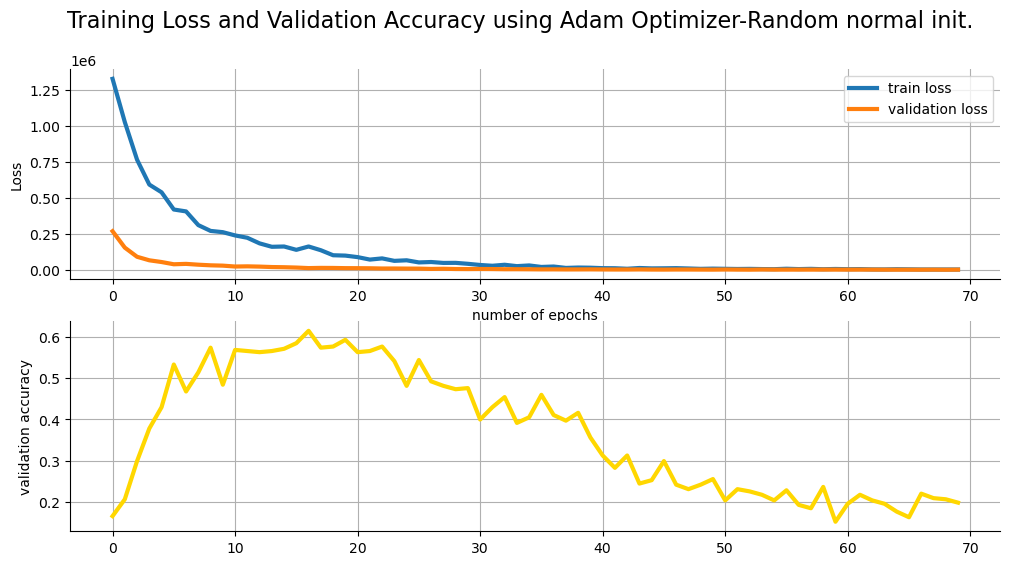

In [79]:
plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3, label = "train loss")
plt.plot(val_loss_list, linewidth = 3, label = "validation loss")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.grid(True)

plt.suptitle("Training Loss and Validation Accuracy using Adam Optimizer-Random normal init.", fontsize=16)

sns.despine()

In [80]:
with torch.no_grad():

    total_accuracies = []
    
    for test_features, test_labels in test_batches:

        model_RN.eval()
        # Reshape test images into a vector
        test_features = test_features.reshape(-1, 28*28)

         # Compute validation outputs (targets) 
        y_pred_test = model_RN(test_features) 
        
         # and compute accuracy 
        batch_correct = (torch.argmax(y_pred_test, dim=1) == test_labels).type(torch.FloatTensor)
        batch_accuracy = batch_correct.mean()
        total_accuracies.append(batch_accuracy.numpy())
      
    # Compute total (mean) accuracy
    testing_acc = np.mean(total_accuracies)
    testing_std = np.std(total_accuracies)

    print("Testing Accuracy: {:.2f}% ± {:.2f}%".format(testing_acc * 100, testing_std * 100))

Testing Accuracy: 18.19% ± 2.27%


**Xavier Initialization**

In [98]:
class ACAIGFCNDropout(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout_rate=0.5):
        super(ACAIGFCNDropout, self).__init__()

        # Define the network layers and activation functions
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims)-1)])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        # Add dropout layers
        self.dropout_layers = nn.ModuleList([nn.Dropout(p=dropout_rate) for _ in range(len(hidden_dims))])

    def forward(self, input):
        # Define how your model propagates the input through the network

        output = torch.nn.functional.tanh(self.input_layer(input))
        
        for hidden_layer, dropout_layer in zip(self.hidden_layers, self.dropout_layers):
            output = torch.nn.functional.tanh(hidden_layer(output))
            output = dropout_layer(output)  # Apply dropout after activation

        output = self.output_layer(output)

        return output

In [99]:
def init_weights_Xavier(m):
    if type(m) == nn.Linear:
        init.xavier_uniform_(m.weight)

model_X = ACAIGFCNDropout(input_dim = 784, output_dim = 10, hidden_dims = hidden_dims, dropout_rate=0.5)
model_X.apply(init_weights_Xavier)

train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))

# Define loss function  and optimizer
loss_func = torch.nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
optimizer = torch.optim.Adam(model_X.parameters(), lr= 0.0001)

for epoch in tqdm.trange(epochs):

    # ACAIGFCNDropout Training 
    for train_features, train_labels in train_batches:
        # Set model into training mode
        model_X.train()
        
        # Reshape images into a vector
        train_features = train_features.reshape(-1, 28*28)

        # Reset gradients, Calculate training loss on model
        optimizer.zero_grad()
        output = model_X(train_features) # foward method
        # Calculate the loss using your loss function and labels
        loss = loss_func(output, train_labels)
    
        train_loss_list[epoch] = loss.item()
        
        loss.backward()
        
        optimizer.step()
        # Perfrom optimization, back propagation
        
 
    # Record loss for the epoch
    
    # ACAIGFCN Validation
    for val_features, val_labels in val_batches:
        
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad(): 
            model_X.eval()
            
             # Reshape validation images into a vector
            val_features = val_features.reshape(-1, 28 * 28)
          
            # Compute validation outputs (targets)
            validation_outputs = model_X(val_features)
            val_loss = loss_func(validation_outputs, val_labels)
            val_loss_list[epoch] = val_loss.item()
            
            correct = (torch.argmax(validation_outputs, dim=1) == val_labels).type(torch.FloatTensor)
        
            validation_accuracy_list[epoch] = correct.mean()
            # and compute accuracy 
            
    # Record accuracy for the epoch; print training loss, validation accuracy
    print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(validation_accuracy_list[epoch].item() * 100) + '%')


  1%|▋                                           | 1/70 [00:03<03:44,  3.25s/it]

Epoch: 0; Validation Accuracy:76.63043737411499%


  3%|█▎                                          | 2/70 [00:06<03:41,  3.26s/it]

Epoch: 1; Validation Accuracy:80.1630437374115%


  4%|█▉                                          | 3/70 [00:09<03:35,  3.22s/it]

Epoch: 2; Validation Accuracy:82.6086938381195%


  6%|██▌                                         | 4/70 [00:12<03:31,  3.21s/it]

Epoch: 3; Validation Accuracy:79.8913061618805%


  7%|███▏                                        | 5/70 [00:16<03:27,  3.19s/it]

Epoch: 4; Validation Accuracy:88.04348111152649%


  9%|███▊                                        | 6/70 [00:19<03:25,  3.21s/it]

Epoch: 5; Validation Accuracy:83.152174949646%


 10%|████▍                                       | 7/70 [00:22<03:21,  3.19s/it]

Epoch: 6; Validation Accuracy:85.05434989929199%


 11%|█████                                       | 8/70 [00:25<03:18,  3.19s/it]

Epoch: 7; Validation Accuracy:88.8586938381195%


 13%|█████▋                                      | 9/70 [00:28<03:14,  3.18s/it]

Epoch: 8; Validation Accuracy:88.5869562625885%


 14%|██████▏                                    | 10/70 [00:31<03:10,  3.18s/it]

Epoch: 9; Validation Accuracy:88.5869562625885%


 16%|██████▊                                    | 11/70 [00:35<03:08,  3.19s/it]

Epoch: 10; Validation Accuracy:91.847825050354%


 17%|███████▎                                   | 12/70 [00:38<03:04,  3.18s/it]

Epoch: 11; Validation Accuracy:89.94565010070801%


 19%|███████▉                                   | 13/70 [00:41<03:02,  3.20s/it]

Epoch: 12; Validation Accuracy:86.6847813129425%


 20%|████████▌                                  | 14/70 [00:44<02:59,  3.20s/it]

Epoch: 13; Validation Accuracy:91.30434989929199%


 21%|█████████▏                                 | 15/70 [00:47<02:55,  3.19s/it]

Epoch: 14; Validation Accuracy:88.04348111152649%


 23%|█████████▊                                 | 16/70 [00:51<02:52,  3.20s/it]

Epoch: 15; Validation Accuracy:88.5869562625885%


 24%|██████████▍                                | 17/70 [00:54<02:49,  3.19s/it]

Epoch: 16; Validation Accuracy:86.95651888847351%


 26%|███████████                                | 18/70 [00:57<02:45,  3.18s/it]

Epoch: 17; Validation Accuracy:89.94565010070801%


 27%|███████████▋                               | 19/70 [01:00<02:42,  3.18s/it]

Epoch: 18; Validation Accuracy:87.5%


 29%|████████████▎                              | 20/70 [01:03<02:38,  3.18s/it]

Epoch: 19; Validation Accuracy:91.03260636329651%


 30%|████████████▉                              | 21/70 [01:07<02:36,  3.20s/it]

Epoch: 20; Validation Accuracy:90.4891312122345%


 31%|█████████████▌                             | 22/70 [01:10<02:33,  3.19s/it]

Epoch: 21; Validation Accuracy:88.8586938381195%


 33%|██████████████▏                            | 23/70 [01:13<02:29,  3.18s/it]

Epoch: 22; Validation Accuracy:88.3152186870575%


 34%|██████████████▋                            | 24/70 [01:16<02:27,  3.20s/it]

Epoch: 23; Validation Accuracy:85.86956262588501%


 36%|███████████████▎                           | 25/70 [01:19<02:23,  3.19s/it]

Epoch: 24; Validation Accuracy:86.95651888847351%


 37%|███████████████▉                           | 26/70 [01:23<02:20,  3.20s/it]

Epoch: 25; Validation Accuracy:88.8586938381195%


 39%|████████████████▌                          | 27/70 [01:26<02:17,  3.20s/it]

Epoch: 26; Validation Accuracy:87.228262424469%


 40%|█████████████████▏                         | 28/70 [01:29<02:14,  3.19s/it]

Epoch: 27; Validation Accuracy:87.228262424469%


 41%|█████████████████▊                         | 29/70 [01:32<02:10,  3.18s/it]

Epoch: 28; Validation Accuracy:87.228262424469%


 43%|██████████████████▍                        | 30/70 [01:35<02:07,  3.20s/it]

Epoch: 29; Validation Accuracy:88.8586938381195%


 44%|███████████████████                        | 31/70 [01:39<02:05,  3.22s/it]

Epoch: 30; Validation Accuracy:90.7608687877655%


 46%|███████████████████▋                       | 32/70 [01:42<02:03,  3.24s/it]

Epoch: 31; Validation Accuracy:89.673912525177%


 47%|████████████████████▎                      | 33/70 [01:45<02:00,  3.25s/it]

Epoch: 32; Validation Accuracy:89.94565010070801%


 49%|████████████████████▉                      | 34/70 [01:48<01:56,  3.22s/it]

Epoch: 33; Validation Accuracy:90.21739363670349%


 50%|█████████████████████▌                     | 35/70 [01:52<01:52,  3.22s/it]

Epoch: 34; Validation Accuracy:88.8586938381195%


 51%|██████████████████████                     | 36/70 [01:55<01:50,  3.24s/it]

Epoch: 35; Validation Accuracy:90.7608687877655%


 53%|██████████████████████▋                    | 37/70 [01:58<01:46,  3.22s/it]

Epoch: 36; Validation Accuracy:88.3152186870575%


 54%|███████████████████████▎                   | 38/70 [02:01<01:42,  3.20s/it]

Epoch: 37; Validation Accuracy:89.13043737411499%


 56%|███████████████████████▉                   | 39/70 [02:04<01:38,  3.19s/it]

Epoch: 38; Validation Accuracy:89.94565010070801%


 57%|████████████████████████▌                  | 40/70 [02:07<01:35,  3.17s/it]

Epoch: 39; Validation Accuracy:91.576087474823%


 59%|█████████████████████████▏                 | 41/70 [02:11<01:32,  3.18s/it]

Epoch: 40; Validation Accuracy:92.6630437374115%


 60%|█████████████████████████▊                 | 42/70 [02:14<01:28,  3.18s/it]

Epoch: 41; Validation Accuracy:88.8586938381195%


 61%|██████████████████████████▍                | 43/70 [02:17<01:25,  3.17s/it]

Epoch: 42; Validation Accuracy:90.21739363670349%


 63%|███████████████████████████                | 44/70 [02:20<01:22,  3.16s/it]

Epoch: 43; Validation Accuracy:88.8586938381195%


 64%|███████████████████████████▋               | 45/70 [02:23<01:19,  3.19s/it]

Epoch: 44; Validation Accuracy:90.7608687877655%


 66%|████████████████████████████▎              | 46/70 [02:27<01:16,  3.19s/it]

Epoch: 45; Validation Accuracy:86.6847813129425%


 67%|████████████████████████████▊              | 47/70 [02:30<01:13,  3.18s/it]

Epoch: 46; Validation Accuracy:86.95651888847351%


 69%|█████████████████████████████▍             | 48/70 [02:33<01:10,  3.18s/it]

Epoch: 47; Validation Accuracy:91.576087474823%


 70%|██████████████████████████████             | 49/70 [02:36<01:06,  3.18s/it]

Epoch: 48; Validation Accuracy:89.402174949646%


 71%|██████████████████████████████▋            | 50/70 [02:39<01:03,  3.17s/it]

Epoch: 49; Validation Accuracy:90.21739363670349%


 73%|███████████████████████████████▎           | 51/70 [02:42<01:00,  3.18s/it]

Epoch: 50; Validation Accuracy:88.04348111152649%


 74%|███████████████████████████████▉           | 52/70 [02:46<00:57,  3.17s/it]

Epoch: 51; Validation Accuracy:92.3913061618805%


 76%|████████████████████████████████▌          | 53/70 [02:49<00:53,  3.17s/it]

Epoch: 52; Validation Accuracy:92.6630437374115%


 77%|█████████████████████████████████▏         | 54/70 [02:52<00:50,  3.17s/it]

Epoch: 53; Validation Accuracy:91.30434989929199%


 79%|█████████████████████████████████▊         | 55/70 [02:55<00:47,  3.17s/it]

Epoch: 54; Validation Accuracy:85.86956262588501%


 80%|██████████████████████████████████▍        | 56/70 [02:58<00:45,  3.23s/it]

Epoch: 55; Validation Accuracy:89.94565010070801%


 81%|███████████████████████████████████        | 57/70 [03:02<00:41,  3.21s/it]

Epoch: 56; Validation Accuracy:88.5869562625885%


 83%|███████████████████████████████████▋       | 58/70 [03:05<00:38,  3.19s/it]

Epoch: 57; Validation Accuracy:89.673912525177%


 84%|████████████████████████████████████▏      | 59/70 [03:08<00:34,  3.17s/it]

Epoch: 58; Validation Accuracy:88.5869562625885%


 86%|████████████████████████████████████▊      | 60/70 [03:11<00:31,  3.18s/it]

Epoch: 59; Validation Accuracy:87.771737575531%


 87%|█████████████████████████████████████▍     | 61/70 [03:14<00:28,  3.19s/it]

Epoch: 60; Validation Accuracy:90.21739363670349%


 89%|██████████████████████████████████████     | 62/70 [03:18<00:25,  3.23s/it]

Epoch: 61; Validation Accuracy:93.478262424469%


 90%|██████████████████████████████████████▋    | 63/70 [03:21<00:22,  3.23s/it]

Epoch: 62; Validation Accuracy:89.402174949646%


 91%|███████████████████████████████████████▎   | 64/70 [03:24<00:19,  3.27s/it]

Epoch: 63; Validation Accuracy:90.21739363670349%


 93%|███████████████████████████████████████▉   | 65/70 [03:28<00:16,  3.29s/it]

Epoch: 64; Validation Accuracy:92.3913061618805%


 94%|████████████████████████████████████████▌  | 66/70 [03:31<00:13,  3.29s/it]

Epoch: 65; Validation Accuracy:89.13043737411499%


 96%|█████████████████████████████████████████▏ | 67/70 [03:34<00:10,  3.34s/it]

Epoch: 66; Validation Accuracy:89.94565010070801%


 97%|█████████████████████████████████████████▊ | 68/70 [03:38<00:06,  3.37s/it]

Epoch: 67; Validation Accuracy:92.3913061618805%


 99%|██████████████████████████████████████████▍| 69/70 [03:41<00:03,  3.31s/it]

Epoch: 68; Validation Accuracy:89.13043737411499%


100%|███████████████████████████████████████████| 70/70 [03:44<00:00,  3.21s/it]

Epoch: 69; Validation Accuracy:87.771737575531%


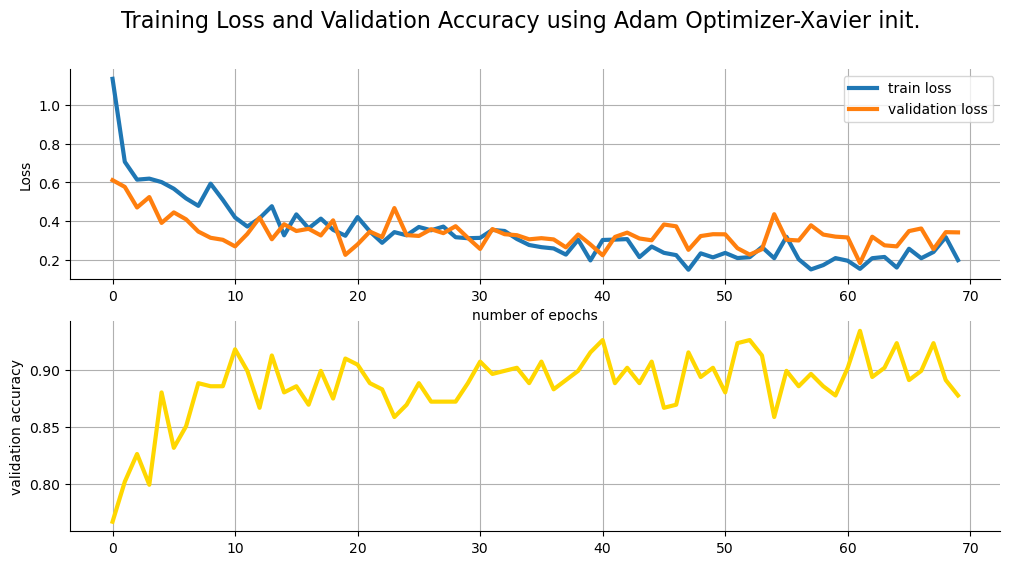

In [100]:
plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3, label = "train loss")
plt.plot(val_loss_list, linewidth = 3, label = "validation loss")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.grid(True)

plt.suptitle("Training Loss and Validation Accuracy using Adam Optimizer-Xavier init.", fontsize=16)

sns.despine()

In [101]:
with torch.no_grad():

    total_accuracies = []
    
    for test_features, test_labels in test_batches:

        model_X.eval()
        # Reshape test images into a vector
        test_features = test_features.reshape(-1, 28*28)

         # Compute validation outputs (targets) 
        y_pred_test = model_X(test_features) 
        
         # and compute accuracy 
        batch_correct = (torch.argmax(y_pred_test, dim=1) == test_labels).type(torch.FloatTensor)
        batch_accuracy = batch_correct.mean()
        total_accuracies.append(batch_accuracy.numpy())
      
    # Compute total (mean) accuracy
    testing_acc = np.mean(total_accuracies)
    testing_std = np.std(total_accuracies)

    print("Testing Accuracy: {:.2f}% ± {:.2f}%".format(testing_acc * 100, testing_std * 100))

Testing Accuracy: 88.70% ± 1.82%


**Kaiming Initialization**

In [111]:
class ACAIGFCNDropout(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout_rate=0.5):
        super(ACAIGFCNDropout, self).__init__()

        # Define the network layers and activation functions
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims)-1)])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        # Add dropout layers
        self.dropout_layers = nn.ModuleList([nn.Dropout(p=dropout_rate) for _ in range(len(hidden_dims))])

    def forward(self, input):
        # Define how your model propagates the input through the network

        output = torch.nn.functional.relu(self.input_layer(input))
        
        for hidden_layer, dropout_layer in zip(self.hidden_layers, self.dropout_layers):
            output = torch.nn.functional.relu(hidden_layer(output))
            output = dropout_layer(output)  # Apply dropout after activation

        output = self.output_layer(output)

        return output

In [125]:

def init_weights_kaiming(m):
    if type(m) == nn.Linear:
        init.kaiming_uniform_(m.weight)

model_K = ACAIGFCNDropout(input_dim = 784, output_dim = 10, hidden_dims = hidden_dims, dropout_rate=0.5)
model_K.apply(init_weights_kaiming)

train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))

# Define loss function  and optimizer
loss_func = torch.nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
optimizer = torch.optim.Adam(model_K.parameters(), lr= 0.0001)

for epoch in tqdm.trange(epochs):

    # ACAIGFCNDropout Training 
    for train_features, train_labels in train_batches:
        # Set model into training mode
        model_K.train()
        
        # Reshape images into a vector
        train_features = train_features.reshape(-1, 28*28)

        # Reset gradients, Calculate training loss on model
        optimizer.zero_grad()
        output = model_K(train_features) # foward method
        # Calculate the loss using your loss function and labels
        loss = loss_func(output, train_labels)
    
        train_loss_list[epoch] = loss.item()
        
        loss.backward()
        
        optimizer.step()
        # Perfrom optimization, back propagation
        
 
    # Record loss for the epoch
    
    # ACAIGFCN Validation
    for val_features, val_labels in val_batches:
        
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad(): 
            model_K.eval()
            
             # Reshape validation images into a vector
            val_features = val_features.reshape(-1, 28 * 28)
          
            # Compute validation outputs (targets)
            validation_outputs = model_K(val_features)
            val_loss = loss_func(validation_outputs, val_labels)
            val_loss_list[epoch] = val_loss.item()
            
            correct = (torch.argmax(validation_outputs, dim=1) == val_labels).type(torch.FloatTensor)
        
            validation_accuracy_list[epoch] = correct.mean()
            # and compute accuracy 
            
    # Record accuracy for the epoch; print training loss, validation accuracy
    print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(validation_accuracy_list[epoch].item() * 100) + '%')


  1%|▋                                           | 1/70 [00:03<03:29,  3.04s/it]

Epoch: 0; Validation Accuracy:70.923912525177%


  3%|█▎                                          | 2/70 [00:06<03:25,  3.02s/it]

Epoch: 1; Validation Accuracy:73.6413061618805%


  4%|█▉                                          | 3/70 [00:09<03:22,  3.02s/it]

Epoch: 2; Validation Accuracy:77.9891312122345%


  6%|██▌                                         | 4/70 [00:12<03:18,  3.01s/it]

Epoch: 3; Validation Accuracy:78.2608687877655%


  7%|███▏                                        | 5/70 [00:15<03:16,  3.03s/it]

Epoch: 4; Validation Accuracy:77.9891312122345%


  9%|███▊                                        | 6/70 [00:18<03:14,  3.05s/it]

Epoch: 5; Validation Accuracy:82.88043737411499%


 10%|████▍                                       | 7/70 [00:21<03:11,  3.03s/it]

Epoch: 6; Validation Accuracy:85.326087474823%


 11%|█████                                       | 8/70 [00:24<03:07,  3.03s/it]

Epoch: 7; Validation Accuracy:82.3369562625885%


 13%|█████▋                                      | 9/70 [00:27<03:04,  3.02s/it]

Epoch: 8; Validation Accuracy:83.96739363670349%


 14%|██████▏                                    | 10/70 [00:30<03:01,  3.02s/it]

Epoch: 9; Validation Accuracy:82.6086938381195%


 16%|██████▊                                    | 11/70 [00:33<02:58,  3.03s/it]

Epoch: 10; Validation Accuracy:84.78260636329651%


 17%|███████▎                                   | 12/70 [00:36<02:55,  3.03s/it]

Epoch: 11; Validation Accuracy:85.597825050354%


 19%|███████▉                                   | 13/70 [00:39<02:52,  3.03s/it]

Epoch: 12; Validation Accuracy:85.326087474823%


 20%|████████▌                                  | 14/70 [00:42<02:49,  3.02s/it]

Epoch: 13; Validation Accuracy:84.5108687877655%


 21%|█████████▏                                 | 15/70 [00:45<02:46,  3.02s/it]

Epoch: 14; Validation Accuracy:86.4130437374115%


 23%|█████████▊                                 | 16/70 [00:48<02:44,  3.04s/it]

Epoch: 15; Validation Accuracy:83.96739363670349%


 24%|██████████▍                                | 17/70 [00:51<02:40,  3.03s/it]

Epoch: 16; Validation Accuracy:87.771737575531%


 26%|███████████                                | 18/70 [00:54<02:38,  3.06s/it]

Epoch: 17; Validation Accuracy:88.5869562625885%


 27%|███████████▋                               | 19/70 [00:57<02:35,  3.04s/it]

Epoch: 18; Validation Accuracy:88.3152186870575%


 29%|████████████▎                              | 20/70 [01:00<02:31,  3.04s/it]

Epoch: 19; Validation Accuracy:85.597825050354%


 30%|████████████▉                              | 21/70 [01:03<02:29,  3.05s/it]

Epoch: 20; Validation Accuracy:87.228262424469%


 31%|█████████████▌                             | 22/70 [01:06<02:26,  3.05s/it]

Epoch: 21; Validation Accuracy:86.4130437374115%


 33%|██████████████▏                            | 23/70 [01:09<02:22,  3.04s/it]

Epoch: 22; Validation Accuracy:86.4130437374115%


 34%|██████████████▋                            | 24/70 [01:12<02:19,  3.03s/it]

Epoch: 23; Validation Accuracy:86.95651888847351%


 36%|███████████████▎                           | 25/70 [01:15<02:16,  3.03s/it]

Epoch: 24; Validation Accuracy:87.771737575531%


 37%|███████████████▉                           | 26/70 [01:18<02:13,  3.04s/it]

Epoch: 25; Validation Accuracy:88.3152186870575%


 39%|████████████████▌                          | 27/70 [01:21<02:10,  3.04s/it]

Epoch: 26; Validation Accuracy:89.94565010070801%


 40%|█████████████████▏                         | 28/70 [01:24<02:07,  3.03s/it]

Epoch: 27; Validation Accuracy:91.847825050354%


 41%|█████████████████▊                         | 29/70 [01:27<02:05,  3.05s/it]

Epoch: 28; Validation Accuracy:89.13043737411499%


 43%|██████████████████▍                        | 30/70 [01:31<02:01,  3.04s/it]

Epoch: 29; Validation Accuracy:89.13043737411499%


 44%|███████████████████                        | 31/70 [01:34<01:58,  3.04s/it]

Epoch: 30; Validation Accuracy:87.771737575531%


 46%|███████████████████▋                       | 32/70 [01:37<01:55,  3.05s/it]

Epoch: 31; Validation Accuracy:89.402174949646%


 47%|████████████████████▎                      | 33/70 [01:40<01:52,  3.04s/it]

Epoch: 32; Validation Accuracy:88.3152186870575%


 49%|████████████████████▉                      | 34/70 [01:43<01:50,  3.07s/it]

Epoch: 33; Validation Accuracy:89.94565010070801%


 50%|█████████████████████▌                     | 35/70 [01:46<01:46,  3.06s/it]

Epoch: 34; Validation Accuracy:88.04348111152649%


 51%|██████████████████████                     | 36/70 [01:49<01:43,  3.05s/it]

Epoch: 35; Validation Accuracy:88.3152186870575%


 53%|██████████████████████▋                    | 37/70 [01:52<01:41,  3.06s/it]

Epoch: 36; Validation Accuracy:90.21739363670349%


 54%|███████████████████████▎                   | 38/70 [01:55<01:37,  3.05s/it]

Epoch: 37; Validation Accuracy:90.21739363670349%


 56%|███████████████████████▉                   | 39/70 [01:58<01:34,  3.05s/it]

Epoch: 38; Validation Accuracy:88.3152186870575%


 57%|████████████████████████▌                  | 40/70 [02:01<01:31,  3.05s/it]

Epoch: 39; Validation Accuracy:87.228262424469%


 59%|█████████████████████████▏                 | 41/70 [02:04<01:28,  3.06s/it]

Epoch: 40; Validation Accuracy:88.04348111152649%


 60%|█████████████████████████▊                 | 42/70 [02:07<01:26,  3.07s/it]

Epoch: 41; Validation Accuracy:88.8586938381195%


 61%|██████████████████████████▍                | 43/70 [02:10<01:22,  3.06s/it]

Epoch: 42; Validation Accuracy:90.4891312122345%


 63%|███████████████████████████                | 44/70 [02:13<01:19,  3.06s/it]

Epoch: 43; Validation Accuracy:89.13043737411499%


 64%|███████████████████████████▋               | 45/70 [02:16<01:16,  3.05s/it]

Epoch: 44; Validation Accuracy:89.402174949646%


 66%|████████████████████████████▎              | 46/70 [02:19<01:13,  3.04s/it]

Epoch: 45; Validation Accuracy:87.5%


 67%|████████████████████████████▊              | 47/70 [02:22<01:10,  3.06s/it]

Epoch: 46; Validation Accuracy:88.3152186870575%


 69%|█████████████████████████████▍             | 48/70 [02:26<01:07,  3.05s/it]

Epoch: 47; Validation Accuracy:87.5%


 70%|██████████████████████████████             | 49/70 [02:29<01:03,  3.05s/it]

Epoch: 48; Validation Accuracy:87.5%


 71%|██████████████████████████████▋            | 50/70 [02:32<01:00,  3.05s/it]

Epoch: 49; Validation Accuracy:91.03260636329651%


 73%|███████████████████████████████▎           | 51/70 [02:35<00:57,  3.05s/it]

Epoch: 50; Validation Accuracy:89.673912525177%


 74%|███████████████████████████████▉           | 52/70 [02:38<00:54,  3.04s/it]

Epoch: 51; Validation Accuracy:90.21739363670349%


 76%|████████████████████████████████▌          | 53/70 [02:41<00:52,  3.08s/it]

Epoch: 52; Validation Accuracy:88.8586938381195%


 77%|█████████████████████████████████▏         | 54/70 [02:44<00:49,  3.07s/it]

Epoch: 53; Validation Accuracy:89.94565010070801%


 79%|█████████████████████████████████▊         | 55/70 [02:47<00:45,  3.06s/it]

Epoch: 54; Validation Accuracy:89.402174949646%


 80%|██████████████████████████████████▍        | 56/70 [02:50<00:42,  3.05s/it]

Epoch: 55; Validation Accuracy:88.8586938381195%


 81%|███████████████████████████████████        | 57/70 [02:53<00:39,  3.05s/it]

Epoch: 56; Validation Accuracy:89.94565010070801%


 83%|███████████████████████████████████▋       | 58/70 [02:56<00:36,  3.07s/it]

Epoch: 57; Validation Accuracy:89.402174949646%


 84%|████████████████████████████████████▏      | 59/70 [02:59<00:33,  3.06s/it]

Epoch: 58; Validation Accuracy:89.673912525177%


 86%|████████████████████████████████████▊      | 60/70 [03:02<00:30,  3.06s/it]

Epoch: 59; Validation Accuracy:90.21739363670349%


 87%|█████████████████████████████████████▍     | 61/70 [03:05<00:27,  3.05s/it]

Epoch: 60; Validation Accuracy:90.4891312122345%


 89%|██████████████████████████████████████     | 62/70 [03:08<00:24,  3.05s/it]

Epoch: 61; Validation Accuracy:90.7608687877655%


 90%|██████████████████████████████████████▋    | 63/70 [03:11<00:21,  3.07s/it]

Epoch: 62; Validation Accuracy:90.21739363670349%


 91%|███████████████████████████████████████▎   | 64/70 [03:14<00:18,  3.06s/it]

Epoch: 63; Validation Accuracy:89.673912525177%


 93%|███████████████████████████████████████▉   | 65/70 [03:18<00:15,  3.08s/it]

Epoch: 64; Validation Accuracy:89.402174949646%


 94%|████████████████████████████████████████▌  | 66/70 [03:21<00:12,  3.07s/it]

Epoch: 65; Validation Accuracy:89.402174949646%


 96%|█████████████████████████████████████████▏ | 67/70 [03:24<00:09,  3.06s/it]

Epoch: 66; Validation Accuracy:90.21739363670349%


 97%|█████████████████████████████████████████▊ | 68/70 [03:27<00:06,  3.07s/it]

Epoch: 67; Validation Accuracy:88.04348111152649%


 99%|██████████████████████████████████████████▍| 69/70 [03:30<00:03,  3.07s/it]

Epoch: 68; Validation Accuracy:88.5869562625885%


100%|███████████████████████████████████████████| 70/70 [03:33<00:00,  3.05s/it]

Epoch: 69; Validation Accuracy:92.3913061618805%


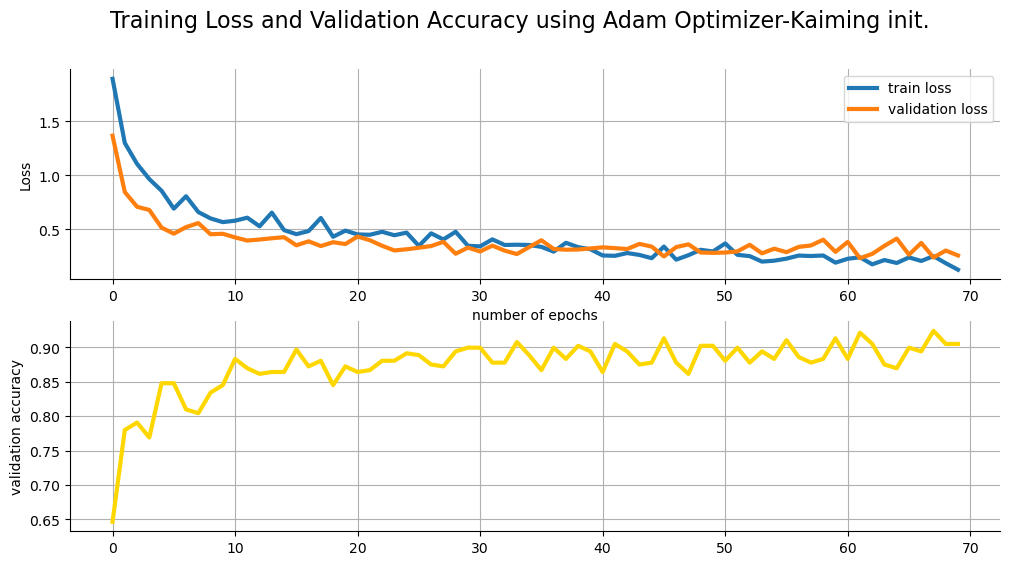

In [107]:
plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3, label = "train loss")
plt.plot(val_loss_list, linewidth = 3, label = "validation loss")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.grid(True)

plt.suptitle("Training Loss and Validation Accuracy using Adam Optimizer-Kaiming init.", fontsize=16)

sns.despine()

In [135]:
with torch.no_grad():

    total_accuracies = []
    
    for test_features, test_labels in test_batches:

        model_K.eval()
        # Reshape test images into a vector
        test_features = test_features.reshape(-1, 28*28)

         # Compute validation outputs (targets) 
        y_pred_test = model_K(test_features) 
        
         # and compute accuracy 
        batch_correct = (torch.argmax(y_pred_test, dim=1) == test_labels).type(torch.FloatTensor)
        batch_accuracy = batch_correct.mean()
        total_accuracies.append(batch_accuracy.numpy())
      
    # Compute total (mean) accuracy
    testing_acc = np.mean(total_accuracies)
    testing_std = np.std(total_accuracies)

    print("Testing Accuracy: {:.2f}% ± {:.2f}%".format(testing_acc * 100, testing_std * 100))

Testing Accuracy: 89.16% ± 1.79%


**Batch Normalization**

In [120]:
# Add batch normalization to dropout model
class ACAIGFCNBN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout_rate=0.5):
        super(ACAIGFCNBN, self).__init__()

        # Define the network layers and activation functions
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims)-1)])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        # Add dropout layers
        self.dropout_layers = nn.ModuleList([nn.Dropout(p=dropout_rate) for _ in range(len(hidden_dims))])
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for hidden_dim in hidden_dims[1:]])

    def forward(self, input):
        # Define how your model propagates the input through the network

        output = torch.nn.functional.relu(self.input_layer(input))
        
        for hidden_layer, dropout_layer, bn_layer in zip(self.hidden_layers, self.dropout_layers, self.bn_layers):
            output = torch.nn.functional.relu(hidden_layer(output))
            output = dropout_layer(output)  # Apply dropout after activation
            output = bn_layer(output)

        output = self.output_layer(output)

        return output
    

In [121]:
model = ACAIGFCNBN(input_dim = 784, output_dim = 10, hidden_dims = hidden_dims, dropout_rate=0.5)

train_loss_list = np.zeros((epochs,))
val_loss_list = np.zeros((epochs,))

validation_accuracy_list = np.zeros((epochs,))

# Define loss function  and optimizer
loss_func = torch.nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)

In [122]:
for epoch in tqdm.trange(epochs):

    # ACAIGFCNDropout Training 
    for train_features, train_labels in train_batches:
        # Set model into training mode
        model.train()
        
        # Reshape images into a vector
        train_features = train_features.reshape(-1, 28*28)

        # Reset gradients, Calculate training loss on model
        optimizer.zero_grad()
        output = model(train_features) # foward method
        # Calculate the loss using your loss function and labels
        loss = loss_func(output, train_labels)
    
        train_loss_list[epoch] = loss.item()
        
        loss.backward()
        
        optimizer.step()
        # Perfrom optimization, back propagation
        
 
    # Record loss for the epoch
    
    # ACAIGFCN Validation
    for val_features, val_labels in val_batches:
        
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad(): 
            model.eval()
            
             # Reshape validation images into a vector
            val_features = val_features.reshape(-1, 28 * 28)
          
            # Compute validation outputs (targets)
            validation_outputs = model(val_features)
            val_loss = loss_func(validation_outputs, val_labels)
            val_loss_list[epoch] = val_loss.item()
            
            correct = (torch.argmax(validation_outputs, dim=1) == val_labels).type(torch.FloatTensor)
        
            validation_accuracy_list[epoch] = correct.mean()
            # and compute accuracy 
            
    # Record accuracy for the epoch; print training loss, validation accuracy
    print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(validation_accuracy_list[epoch].item() * 100) + '%')


  1%|▋                                           | 1/70 [00:03<03:43,  3.24s/it]

Epoch: 0; Validation Accuracy:76.3586938381195%


  3%|█▎                                          | 2/70 [00:06<03:38,  3.22s/it]

Epoch: 1; Validation Accuracy:82.88043737411499%


  4%|█▉                                          | 3/70 [00:09<03:34,  3.20s/it]

Epoch: 2; Validation Accuracy:85.05434989929199%


  6%|██▌                                         | 4/70 [00:12<03:33,  3.23s/it]

Epoch: 3; Validation Accuracy:84.5108687877655%


  7%|███▏                                        | 5/70 [00:16<03:29,  3.22s/it]

Epoch: 4; Validation Accuracy:84.5108687877655%


  9%|███▊                                        | 6/70 [00:19<03:25,  3.21s/it]

Epoch: 5; Validation Accuracy:86.95651888847351%


 10%|████▍                                       | 7/70 [00:22<03:22,  3.22s/it]

Epoch: 6; Validation Accuracy:88.8586938381195%


 11%|█████                                       | 8/70 [00:25<03:19,  3.21s/it]

Epoch: 7; Validation Accuracy:89.94565010070801%


 13%|█████▋                                      | 9/70 [00:28<03:16,  3.22s/it]

Epoch: 8; Validation Accuracy:86.1413061618805%


 14%|██████▏                                    | 10/70 [00:32<03:12,  3.21s/it]

Epoch: 9; Validation Accuracy:88.3152186870575%


 16%|██████▊                                    | 11/70 [00:35<03:08,  3.20s/it]

Epoch: 10; Validation Accuracy:89.13043737411499%


 17%|███████▎                                   | 12/70 [00:38<03:05,  3.20s/it]

Epoch: 11; Validation Accuracy:89.402174949646%


 19%|███████▉                                   | 13/70 [00:41<03:02,  3.19s/it]

Epoch: 12; Validation Accuracy:88.8586938381195%


 20%|████████▌                                  | 14/70 [00:44<03:00,  3.22s/it]

Epoch: 13; Validation Accuracy:89.94565010070801%


 21%|█████████▏                                 | 15/70 [00:48<02:56,  3.21s/it]

Epoch: 14; Validation Accuracy:89.13043737411499%


 23%|█████████▊                                 | 16/70 [00:51<02:53,  3.20s/it]

Epoch: 15; Validation Accuracy:88.04348111152649%


 24%|██████████▍                                | 17/70 [00:54<02:49,  3.20s/it]

Epoch: 16; Validation Accuracy:91.576087474823%


 26%|███████████                                | 18/70 [00:57<02:47,  3.22s/it]

Epoch: 17; Validation Accuracy:89.94565010070801%


 27%|███████████▋                               | 19/70 [01:01<02:45,  3.24s/it]

Epoch: 18; Validation Accuracy:88.04348111152649%


 29%|████████████▎                              | 20/70 [01:04<02:41,  3.22s/it]

Epoch: 19; Validation Accuracy:87.5%


 30%|████████████▉                              | 21/70 [01:07<02:37,  3.21s/it]

Epoch: 20; Validation Accuracy:88.5869562625885%


 31%|█████████████▌                             | 22/70 [01:10<02:33,  3.20s/it]

Epoch: 21; Validation Accuracy:88.04348111152649%


 33%|██████████████▏                            | 23/70 [01:13<02:30,  3.20s/it]

Epoch: 22; Validation Accuracy:89.94565010070801%


 34%|██████████████▋                            | 24/70 [01:17<02:29,  3.25s/it]

Epoch: 23; Validation Accuracy:89.673912525177%


 36%|███████████████▎                           | 25/70 [01:20<02:25,  3.23s/it]

Epoch: 24; Validation Accuracy:91.03260636329651%


 37%|███████████████▉                           | 26/70 [01:23<02:21,  3.22s/it]

Epoch: 25; Validation Accuracy:91.847825050354%


 39%|████████████████▌                          | 27/70 [01:26<02:18,  3.21s/it]

Epoch: 26; Validation Accuracy:90.21739363670349%


 40%|█████████████████▏                         | 28/70 [01:29<02:14,  3.21s/it]

Epoch: 27; Validation Accuracy:89.13043737411499%


 41%|█████████████████▊                         | 29/70 [01:33<02:12,  3.22s/it]

Epoch: 28; Validation Accuracy:89.94565010070801%


 43%|██████████████████▍                        | 30/70 [01:36<02:09,  3.25s/it]

Epoch: 29; Validation Accuracy:89.402174949646%


 44%|███████████████████                        | 31/70 [01:39<02:06,  3.24s/it]

Epoch: 30; Validation Accuracy:90.7608687877655%


 46%|███████████████████▋                       | 32/70 [01:42<02:02,  3.23s/it]

Epoch: 31; Validation Accuracy:92.11956262588501%


 47%|████████████████████▎                      | 33/70 [01:46<01:59,  3.23s/it]

Epoch: 32; Validation Accuracy:90.21739363670349%


 49%|████████████████████▉                      | 34/70 [01:49<01:56,  3.24s/it]

Epoch: 33; Validation Accuracy:89.402174949646%


 50%|█████████████████████▌                     | 35/70 [01:52<01:53,  3.23s/it]

Epoch: 34; Validation Accuracy:89.673912525177%


 51%|██████████████████████                     | 36/70 [01:55<01:49,  3.23s/it]

Epoch: 35; Validation Accuracy:89.94565010070801%


 53%|██████████████████████▋                    | 37/70 [01:59<01:46,  3.22s/it]

Epoch: 36; Validation Accuracy:91.847825050354%


 54%|███████████████████████▎                   | 38/70 [02:02<01:43,  3.22s/it]

Epoch: 37; Validation Accuracy:93.478262424469%


 56%|███████████████████████▉                   | 39/70 [02:05<01:40,  3.23s/it]

Epoch: 38; Validation Accuracy:90.4891312122345%


 57%|████████████████████████▌                  | 40/70 [02:08<01:36,  3.23s/it]

Epoch: 39; Validation Accuracy:89.402174949646%


 59%|█████████████████████████▏                 | 41/70 [02:12<01:33,  3.23s/it]

Epoch: 40; Validation Accuracy:85.86956262588501%


 60%|█████████████████████████▊                 | 42/70 [02:15<01:31,  3.25s/it]

Epoch: 41; Validation Accuracy:89.402174949646%


 61%|██████████████████████████▍                | 43/70 [02:18<01:27,  3.26s/it]

Epoch: 42; Validation Accuracy:89.13043737411499%


 63%|███████████████████████████                | 44/70 [02:21<01:24,  3.25s/it]

Epoch: 43; Validation Accuracy:88.8586938381195%


 64%|███████████████████████████▋               | 45/70 [02:25<01:21,  3.24s/it]

Epoch: 44; Validation Accuracy:90.7608687877655%


 66%|████████████████████████████▎              | 46/70 [02:28<01:17,  3.24s/it]

Epoch: 45; Validation Accuracy:93.20651888847351%


 67%|████████████████████████████▊              | 47/70 [02:31<01:14,  3.23s/it]

Epoch: 46; Validation Accuracy:90.7608687877655%


 69%|█████████████████████████████▍             | 48/70 [02:34<01:11,  3.25s/it]

Epoch: 47; Validation Accuracy:92.9347813129425%


 70%|██████████████████████████████             | 49/70 [02:38<01:08,  3.25s/it]

Epoch: 48; Validation Accuracy:89.673912525177%


 71%|██████████████████████████████▋            | 50/70 [02:41<01:04,  3.24s/it]

Epoch: 49; Validation Accuracy:87.228262424469%


 73%|███████████████████████████████▎           | 51/70 [02:44<01:01,  3.24s/it]

Epoch: 50; Validation Accuracy:88.04348111152649%


 74%|███████████████████████████████▉           | 52/70 [02:47<00:58,  3.23s/it]

Epoch: 51; Validation Accuracy:91.576087474823%


 76%|████████████████████████████████▌          | 53/70 [02:51<00:55,  3.28s/it]

Epoch: 52; Validation Accuracy:89.94565010070801%


 77%|█████████████████████████████████▏         | 54/70 [02:54<00:52,  3.26s/it]

Epoch: 53; Validation Accuracy:92.11956262588501%


 79%|█████████████████████████████████▊         | 55/70 [02:57<00:48,  3.26s/it]

Epoch: 54; Validation Accuracy:90.4891312122345%


 80%|██████████████████████████████████▍        | 56/70 [03:00<00:45,  3.25s/it]

Epoch: 55; Validation Accuracy:92.6630437374115%


 81%|███████████████████████████████████        | 57/70 [03:04<00:42,  3.25s/it]

Epoch: 56; Validation Accuracy:89.402174949646%


 83%|███████████████████████████████████▋       | 58/70 [03:07<00:39,  3.26s/it]

Epoch: 57; Validation Accuracy:89.673912525177%


 84%|████████████████████████████████████▏      | 59/70 [03:10<00:35,  3.25s/it]

Epoch: 58; Validation Accuracy:89.402174949646%


 86%|████████████████████████████████████▊      | 60/70 [03:13<00:32,  3.25s/it]

Epoch: 59; Validation Accuracy:89.94565010070801%


 87%|█████████████████████████████████████▍     | 61/70 [03:17<00:29,  3.24s/it]

Epoch: 60; Validation Accuracy:89.13043737411499%


 89%|██████████████████████████████████████     | 62/70 [03:20<00:25,  3.24s/it]

Epoch: 61; Validation Accuracy:91.847825050354%


 90%|██████████████████████████████████████▋    | 63/70 [03:23<00:22,  3.26s/it]

Epoch: 62; Validation Accuracy:88.04348111152649%


 91%|███████████████████████████████████████▎   | 64/70 [03:26<00:19,  3.25s/it]

Epoch: 63; Validation Accuracy:90.4891312122345%


 93%|███████████████████████████████████████▉   | 65/70 [03:30<00:16,  3.27s/it]

Epoch: 64; Validation Accuracy:90.21739363670349%


 94%|████████████████████████████████████████▌  | 66/70 [03:33<00:13,  3.26s/it]

Epoch: 65; Validation Accuracy:92.9347813129425%


 96%|█████████████████████████████████████████▏ | 67/70 [03:36<00:09,  3.25s/it]

Epoch: 66; Validation Accuracy:90.4891312122345%


 97%|█████████████████████████████████████████▊ | 68/70 [03:39<00:06,  3.27s/it]

Epoch: 67; Validation Accuracy:89.673912525177%


 99%|██████████████████████████████████████████▍| 69/70 [03:43<00:03,  3.26s/it]

Epoch: 68; Validation Accuracy:93.478262424469%


100%|███████████████████████████████████████████| 70/70 [03:46<00:00,  3.23s/it]

Epoch: 69; Validation Accuracy:88.5869562625885%


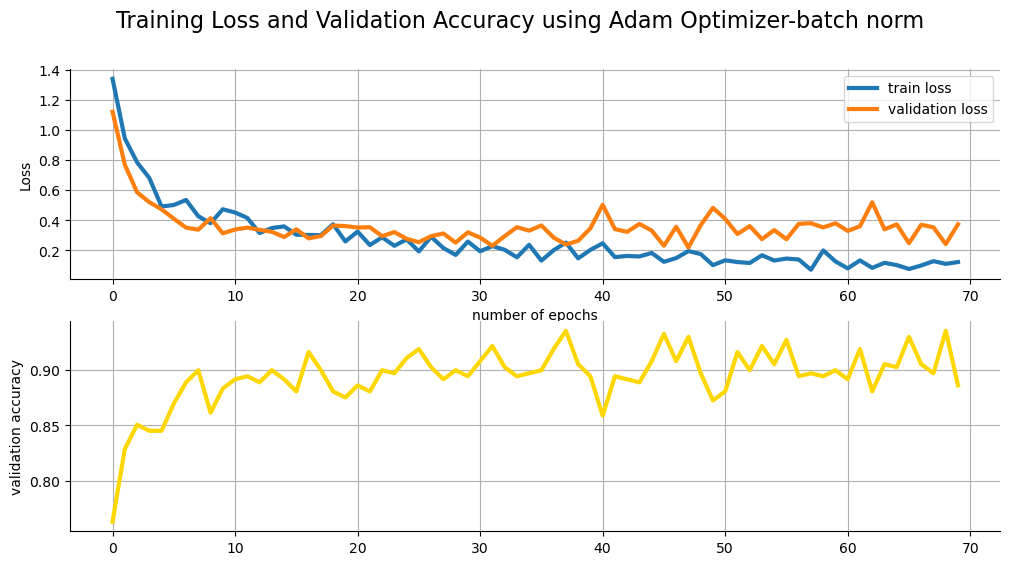

In [123]:
plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3, label = "train loss")
plt.plot(val_loss_list, linewidth = 3, label = "validation loss")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.grid(True)

plt.suptitle("Training Loss and Validation Accuracy using Adam Optimizer-batch norm", fontsize=16)

sns.despine()

In [124]:
with torch.no_grad():

    total_accuracies = []
    
    for test_features, test_labels in test_batches:

        model.eval()
        # Reshape test images into a vector
        test_features = test_features.reshape(-1, 28*28)

         # Compute validation outputs (targets) 
        y_pred_test = model(test_features) 
        
         # and compute accuracy 
        batch_correct = (torch.argmax(y_pred_test, dim=1) == test_labels).type(torch.FloatTensor)
        batch_accuracy = batch_correct.mean()
        total_accuracies.append(batch_accuracy.numpy())
      
    # Compute total (mean) accuracy
    testing_acc = np.mean(total_accuracies)
    testing_std = np.std(total_accuracies)

    print("Testing Accuracy: {:.2f}% ± {:.2f}%".format(testing_acc * 100, testing_std * 100))

Testing Accuracy: 89.55% ± 1.73%
